## Model

In [1]:
#name = 'test_011'
name = 'test_104'
batch_size = 128
model_basename = 'LensResNN2'
train_steps = 20000
Base = '/data/storage1/LensFinder'
import sys; sys.argv=['', 
                      '--log_dir', '{}/log/{}'.format(Base,name), 
                      '--model_dir', '{}/model/{}'.format(Base,name), 
                      '--batch_size', '%d'%batch_size,
                      '--model_basename', model_basename,
                      '--train_steps', '%d'%train_steps,
                      '--learning_rate', '1e-4',
                      '--Is_BN', 'True',
                      '--weight_decay','1e-1',
                     ];
del sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import tensorflow as tf
import numpy as np
import tqdm
tf.logging.set_verbosity(tf.logging.INFO)

/home/mtx/local/anaconda2/envs/tf1.5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tftool.main import Main

In [4]:
class RunWapper(Main):
    def __init__(self, *args, **kwargs):
        super(RunWapper, self).__init__(*args, **kwargs)
        self.data_shape = [101,101,3]
    def __call__(self):
        """an example for constructing network model"""
        self.train_filenames = ["{}/{}/training.tfrecords".format(Base,'dataset_old')]
        self.valid_filenames = ["{}/{}/valid.tfrecords".format(Base,'dataset_old')]
        self.Is_training = tf.placeholder(tf.bool,shape=[],name='is_train')
        x, y_ = self.loaddata(repeat=1,shuffle=True)
        net = self.inference(x, is_training=self.Is_training)
        loss = self.Loss_fn(self, net=net, y_=y_)
        train_op = self.optimizer(loss, gclip=0.1)
        self.train(loss, train_op)  
    
    def eval(self, flux, label):
        BS = self.FLAGS.batch_size
        label = label.astype(np.int32)
        print flux.dtype, flux.shape
        print label.dtype, label.shape
        if label.shape[0]%BS == 0:
            loop_num = label.shape[0]//BS
        else:
            loop_num = label.shape[0]//BS + 1
        print "loop number: %d"%loop_num
        #------------------------------------------------------------
        x = tf.placeholder(tf.float32, shape=[None] + self.data_shape)
        y_ = tf.placeholder(tf.int32, shape=[None])
        net = self.inference(x, is_training=False)
        loss = self.Loss_fn(self, net=net, y_=y_)
        prob = tf.get_collection('prob')[0]
        LOSS = []
        PROB = []
        with tf.Session(config=self.config) as sess:
            self.Saver = tf.train.Saver(max_to_keep=1)
            self.init_model(sess)
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            for i in tqdm.tqdm(xrange(loop_num)):
                el, ep, = sess.run([loss, prob], 
                                   feed_dict={x:flux[i*BS:(i+1)*BS],
                                              y_:label[i*BS:(i+1)*BS]})
                LOSS.append(el)
                PROB.append(ep)
            coord.request_stop()
            coord.join(threads)
        LOSS = np.array(LOSS)
        PROB = np.vstack(PROB)
        return LOSS, PROB
dsc = RunWapper()
print dsc.FLAGS

INFO:tensorflow:(<class 'tftool.main.Main'>, <class 'tftool.Train.Train'>, <class 'tftool.Network.Model'>, <class 'tftool.InputPipeline.InputPipeline'>, <class 'tftool.Utils.Toolkit'>, <class 'tftool.Base.Base'>, <type 'object'>)
Namespace(Is_BN=True, batch_size=128, learning_rate=0.0001, log_dir='/data/storage1/LensFinder/log/test_104', model_basename='LensResNN2', model_dir='/data/storage1/LensFinder/model/test_104', train_steps=20000, weight_decay=0.1)


In [5]:
config = tf.ConfigProto(allow_soft_placement=True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1.0)
config.gpu_options.allow_growth = True
dsc.opt = tf.train.AdamOptimizer
#dsc.opt = tf.train.GradientDescentOptimizer
dsc.Is_summary = True
dsc.update_log_step =100
dsc.save_per_steps = 1000
dsc.print_log = False 
dsc.valid_size = 1024*4
dsc.config = config

### training

In [6]:
dsc()

Tensor("InputPipeline/parse_fn/InputPipeline/preprocessing/clip_by_value:0", shape=(101, 101, 3), dtype=float32) Tensor("InputPipeline/parse_fn/InputPipeline/preprocessing/Reshape_1:0", shape=(), dtype=int32)
INFO:tensorflow:Tensor("InputPipeline/input_fn/IteratorGetNext:0", shape=(?, 101, 101, 3), dtype=float32)
INFO:tensorflow:==========ResNet_sigmoid==========
Tensor("model/reshape_1:0", shape=(?, 1568), dtype=float32)
INFO:tensorflow:load variable from /data/storage1/LensFinder/model/test_104/LensResNN2-14999
INFO:tensorflow:Restoring parameters from /data/storage1/LensFinder/model/test_104/LensResNN2-14999


  1%|          | 200/20000 [00:19<29:16, 11.27it/s]

epoch 1: 0.397529


  2%|▏         | 400/20000 [00:50<29:53, 10.93it/s]

epoch 2: 0.417508


  4%|▍         | 800/20000 [01:16<29:24, 10.88it/s]

epoch 3: 0.550021


  5%|▌         | 1000/20000 [01:35<29:47, 10.63it/s]

epoch 4: 0.942252


  6%|▌         | 1200/20000 [02:10<29:51, 10.49it/s]

epoch 5: 0.372060


  8%|▊         | 1600/20000 [02:32<28:48, 10.64it/s]

epoch 6: 0.308988


  9%|▉         | 1800/20000 [02:52<28:52, 10.51it/s]

epoch 7: 0.420196


 10%|█         | 2000/20000 [03:12<28:51, 10.40it/s]

epoch 8: 0.318227


 12%|█▏        | 2400/20000 [03:49<27:40, 10.60it/s]

epoch 9: 0.992118


 13%|█▎        | 2600/20000 [04:20<27:40, 10.48it/s]

epoch 10: 0.266889


 14%|█▍        | 2800/20000 [04:40<27:35, 10.39it/s]

epoch 11: 0.488209


 16%|█▌        | 3200/20000 [05:06<26:27, 10.58it/s]

epoch 12: 0.441648


 17%|█▋        | 3400/20000 [05:25<26:25, 10.47it/s]

epoch 13: 0.248121


 19%|█▉        | 3800/20000 [06:03<25:21, 10.65it/s]

epoch 14: 0.295855


 20%|██        | 4000/20000 [06:23<25:25, 10.49it/s]

epoch 15: 0.351881


 21%|██        | 4200/20000 [06:42<25:21, 10.38it/s]

epoch 16: 0.389405


 23%|██▎       | 4600/20000 [07:20<24:15, 10.58it/s]

epoch 17: 0.599149


 25%|██▌       | 5000/20000 [08:10<23:23, 10.69it/s]

epoch 18: 1.080134


 27%|██▋       | 5400/20000 [08:34<22:38, 10.75it/s]

epoch 19: 0.317706


 28%|██▊       | 5600/20000 [08:54<22:42, 10.57it/s]

epoch 20: 0.498403


 29%|██▉       | 5800/20000 [09:30<22:36, 10.47it/s]

epoch 21: 0.315064


 31%|███       | 6200/20000 [09:51<21:37, 10.64it/s]

epoch 22: 0.471516


 32%|███▏      | 6400/20000 [10:10<21:31, 10.53it/s]

epoch 23: 0.264012


 34%|███▍      | 6800/20000 [10:47<20:31, 10.72it/s]

epoch 24: 0.746571


 35%|███▌      | 7000/20000 [11:07<20:32, 10.55it/s]

epoch 25: 0.462607


 36%|███▌      | 7200/20000 [11:40<20:26, 10.44it/s]

epoch 26: 0.484434


 38%|███▊      | 7600/20000 [12:04<19:24, 10.64it/s]

epoch 27: 0.413190


 39%|███▉      | 7800/20000 [12:23<19:19, 10.52it/s]

epoch 28: 0.510698


 40%|████      | 8000/20000 [12:43<19:10, 10.43it/s]

epoch 29: 0.791252


 42%|████▏     | 8400/20000 [13:20<18:09, 10.65it/s]

epoch 30: 0.457018


 43%|████▎     | 8600/20000 [13:50<18:03, 10.53it/s]

epoch 31: 0.327428


 44%|████▍     | 8800/20000 [14:10<17:53, 10.43it/s]

epoch 32: 0.632596


 46%|████▌     | 9200/20000 [14:37<16:56, 10.63it/s]

epoch 33: 0.712598


 47%|████▋     | 9400/20000 [14:56<16:49, 10.50it/s]

epoch 34: 0.476250


 49%|████▉     | 9800/20000 [15:33<15:53, 10.70it/s]

epoch 35: 0.386752


 50%|█████     | 10000/20000 [15:53<15:51, 10.51it/s]

epoch 36: 0.709786


 51%|█████     | 10200/20000 [16:12<15:38, 10.44it/s]

epoch 37: 0.487332


 53%|█████▎    | 10600/20000 [16:50<14:42, 10.65it/s]

epoch 38: 0.239742


 54%|█████▍    | 10800/20000 [17:09<14:33, 10.53it/s]

epoch 39: 0.533685


 55%|█████▌    | 11000/20000 [17:41<14:24, 10.41it/s]

epoch 40: 0.348213


 57%|█████▋    | 11400/20000 [18:06<13:28, 10.64it/s]

epoch 41: 0.548241


 58%|█████▊    | 11600/20000 [18:25<13:18, 10.52it/s]

epoch 42: 0.434201


 59%|█████▉    | 11800/20000 [19:01<13:05, 10.44it/s]

epoch 43: 0.434187


 61%|██████    | 12200/20000 [19:22<12:13, 10.64it/s]

epoch 44: 0.316192


 62%|██████▏   | 12400/20000 [19:42<12:01, 10.53it/s]

epoch 45: 0.351355


 63%|██████▎   | 12600/20000 [20:01<11:49, 10.43it/s]

epoch 46: 0.490536


 65%|██████▌   | 13000/20000 [20:39<10:58, 10.63it/s]

epoch 47: 0.340316


 66%|██████▌   | 13200/20000 [21:11<10:46, 10.51it/s]

epoch 48: 0.414180


 68%|██████▊   | 13600/20000 [21:35<09:58, 10.69it/s]

epoch 49: 0.814402


 69%|██████▉   | 13800/20000 [21:55<09:48, 10.54it/s]

epoch 50: 0.309877


 70%|███████   | 14000/20000 [22:14<09:35, 10.42it/s]

epoch 51: 0.467400


 72%|███████▏  | 14400/20000 [22:52<08:46, 10.63it/s]

epoch 52: 0.584934


 73%|███████▎  | 14600/20000 [23:11<08:33, 10.51it/s]

epoch 53: 0.843973


 74%|███████▍  | 14800/20000 [23:41<08:18, 10.42it/s]

epoch 54: 0.381759


 76%|███████▌  | 15200/20000 [24:08<07:31, 10.63it/s]

epoch 55: 0.404425


 77%|███████▋  | 15400/20000 [24:28<07:17, 10.51it/s]

epoch 56: 0.507810


 78%|███████▊  | 15600/20000 [25:01<07:02, 10.41it/s]

epoch 57: 0.450236


 80%|████████  | 16000/20000 [25:24<06:16, 10.61it/s]

epoch 58: 0.454282


 81%|████████  | 16200/20000 [25:44<06:01, 10.50it/s]

epoch 59: 0.451905


 83%|████████▎ | 16600/20000 [26:21<05:17, 10.69it/s]

epoch 60: 0.991624


 84%|████████▍ | 16800/20000 [26:41<05:03, 10.56it/s]

epoch 61: 0.627861


 85%|████████▌ | 17000/20000 [27:11<04:47, 10.43it/s]

epoch 62: 0.481660


 87%|████████▋ | 17400/20000 [27:37<04:03, 10.67it/s]

epoch 63: 0.587184


 88%|████████▊ | 17600/20000 [27:57<03:47, 10.54it/s]

epoch 64: 0.607237


 89%|████████▉ | 17800/20000 [28:31<03:30, 10.46it/s]

epoch 65: 0.435228


 91%|█████████ | 18200/20000 [28:54<02:49, 10.64it/s]

epoch 66: 0.651369


 92%|█████████▏| 18400/20000 [29:13<02:31, 10.53it/s]

epoch 67: 0.424678


 93%|█████████▎| 18600/20000 [29:33<02:14, 10.45it/s]

epoch 68: 0.748175


 95%|█████████▌| 19000/20000 [30:10<01:33, 10.64it/s]

epoch 69: 0.538742


 96%|█████████▌| 19200/20000 [30:42<01:16, 10.52it/s]

epoch 70: 0.548687


 98%|█████████▊| 19600/20000 [31:06<00:37, 10.71it/s]

epoch 71: 0.465228


 99%|█████████▉| 19800/20000 [31:26<00:18, 10.55it/s]

epoch 72: 0.409259


100%|██████████| 20000/20000 [31:46<00:00, 10.43it/s]


---
## Evaluation

In [6]:
def show(data, p, cut=100):
    data = np.clip(data, -cut, cut)
    fig, axes = plt.subplots(1,4,figsize=(4.5*4,4.5))
    ax = axes[0]
    ax.set_ylabel('{}'.format(p))
    ax.imshow(data[:,:,0])
    ax.invert_yaxis()
    ax = axes[1]
    ax.imshow(data[:,:,1])
    ax.invert_yaxis()
    ax = axes[2]
    ax.imshow(data[:,:,2])
    ax.invert_yaxis()
    ax = axes[3]
    ax.imshow(data)
    ax.invert_yaxis()

In [7]:
data_test = np.load('{}/dataset_old/test.npy'.format(Base))

In [8]:
with open(os.path.join(dsc.FLAGS.model_dir,'checkpoint')) as f:
    mid = f.readline().split('/')
    mid = mid[-2]+'_'+mid[-1][:-2]

In [9]:
loss, prob = dsc.eval(data_test['image'], data_test['label'])

float32 (2232, 101, 101, 3)
int32 (2232,)
loop number: 35
INFO:tensorflow:Tensor("Placeholder:0", shape=(?, 101, 101, 3), dtype=float32)
INFO:tensorflow:==========ResNet_sigmoid==========
Tensor("model/reshape_1:0", shape=(?, 1568), dtype=float32)
INFO:tensorflow:load variable from /data/storage1/LensFinder/model/test_011/LensResNN2-5999
INFO:tensorflow:Restoring parameters from /data/storage1/LensFinder/model/test_011/LensResNN2-5999


100%|██████████| 35/35 [00:01<00:00, 27.69it/s]


In [10]:
%config InlineBackend.figure_format = 'retina' 

In [11]:
import matplotlib.pyplot as plt
params = {
    'axes.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'text.usetex': False,
    'figure.figsize': [4.5, 4.5],
    #----------
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'image.cmap': 'jet',
    'legend.frameon':  False,
    'xtick.top': True,
    'ytick.right': True,
    #----------
    'lines.linewidth': 2.0,
#    'axes.labelsize': 12,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.minor.top': True, 
    'xtick.minor.bottom': True, 
    'ytick.minor.left': True, 
    'ytick.minor.right': True,
   }
plt.rcParams.update(params)

0.26924467
| class | percentage | 
|-------|-------|
| lens -> lens | 0.012992831541218637  | 
| nlens-> nlens| 0.932347670250896  | 
| lens -> nlens| 0.0017921146953405018  | 
| nlens-> lens | 0.0528673835125448  | 


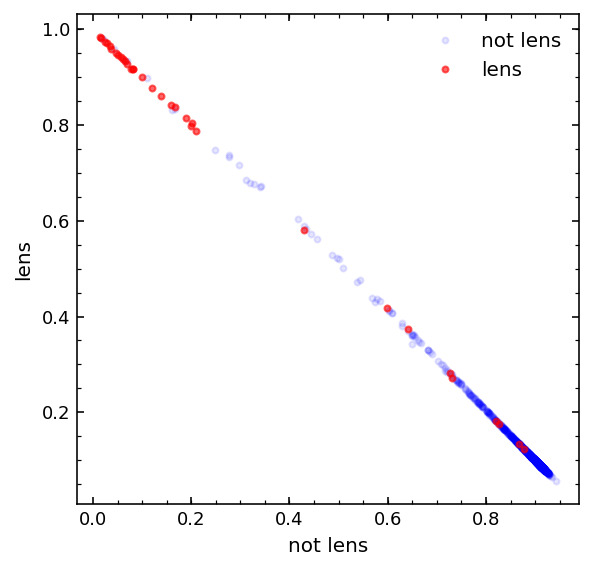

/home/mtx/local/anaconda2/envs/tf1.5/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


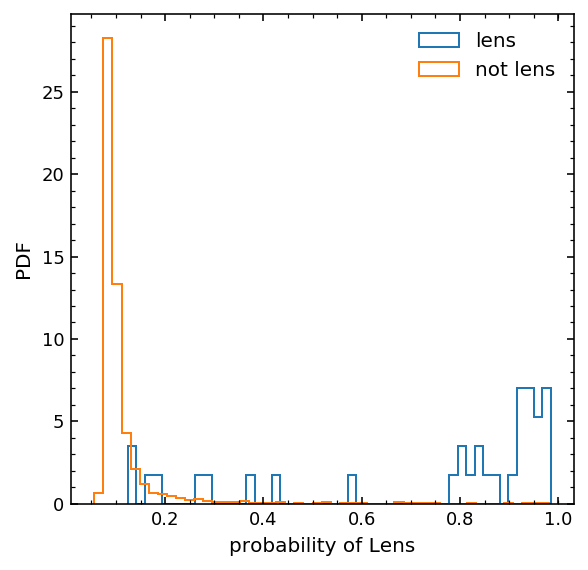

In [12]:
plt.rcParams.update(params)
print loss.mean()
threshold_d = 0.2
threshold_s = 0.8
bool_gt = data_test['label']
bool_es = (prob[:,1]>threshold_d) * (prob[:,0]<threshold_s)
size_eval = data_test.shape[0]
bool_dd = bool_gt*bool_es
bool_ss = (1-bool_gt)*(1-bool_es)
bool_ds = bool_gt*(1-bool_es)
bool_sd = (1-bool_gt)*bool_es
print '| class | percentage |', '\n|-------|-------|'
print '| lens -> lens |', np.sum(bool_dd)/float(size_eval), ' | ' # d -> d
print '| nlens-> nlens|', np.sum(bool_ss)/float(size_eval), ' | '  # s -> s
print '| lens -> nlens|', np.sum(bool_ds)/float(size_eval), ' | '  # d -> s
print '| nlens-> lens |', np.sum(bool_sd)/float(size_eval), ' | '  # s -> d

plt.plot(prob[bool_gt==0][:,0], prob[bool_gt==0][:,1], 'b.', label='not lens', alpha=0.1)
plt.plot(prob[bool_gt==1][:,0], prob[bool_gt==1][:,1], 'r.', label='lens', alpha=0.6)
plt.xlabel('not lens')
plt.ylabel('lens')
plt.legend()
plt.show()

plt.hist(prob[bool_gt==1][:,1], 50, normed=True, histtype='step', label='lens')
plt.hist(prob[bool_gt==0][:,1], 50, normed=True, histtype='step', label='not lens')
plt.xlabel('probability of Lens')
plt.ylabel('PDF')
plt.legend()
#plt.savefig('./test/%s_test.png'%(mid))
plt.show()

## receiver operating characteristic curve ([ROC curve](https://blog.csdn.net/sjyttkl/article/details/80523690))
single: negative; binary: positive
- **true positive (TP)**: binary -> binary
- **true negative (TN)**: single -> single
- **false positive (FP)**: single -> binary
- **false negative (FN)**: binary -> single
- TPR = TP/(TP+FN)
- FPR = FP/(FP+TN)

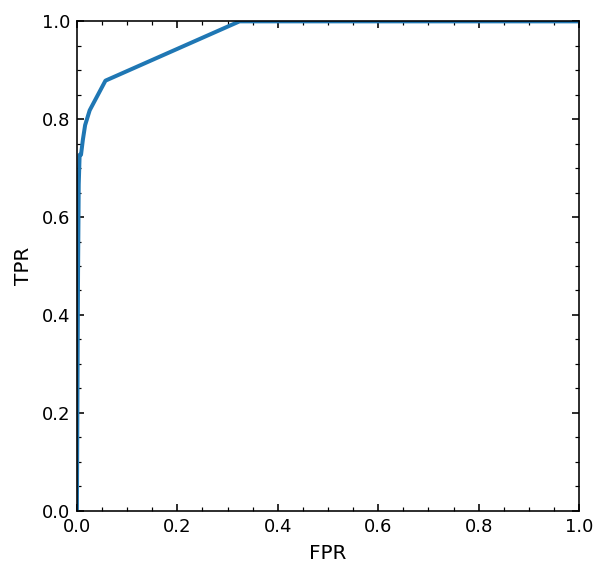

In [13]:
prob_norm = prob / prob.sum(axis=1,keepdims=True)
TPR = []
FPR = []
for threshold_d in np.arange(11)*0.1:
    bool_gt = data_test['label']
    bool_es = (prob[:,1]>threshold_d)
    size_eval = data_test.shape[0]

    bool_dd = bool_gt*bool_es
    bool_ss = (1-bool_gt)*(1-bool_es)
    bool_ds = bool_gt*(1-bool_es)
    bool_sd = (1-bool_gt)*bool_es
    TP = np.sum(bool_dd)/float(size_eval)
    TN = np.sum(bool_ss)/float(size_eval)
    FP = np.sum(bool_sd)/float(size_eval)
    FN = np.sum(bool_ds)/float(size_eval)
    TPR.append(1. * TP / (TP+FN))
    FPR.append(1. * FP / (FP+TN))
plt.plot(FPR, TPR)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [14]:
images = data_test['image']
labels = data_test['label']
bool_sel = labels == 1
P = prob[:,1]/prob.sum(axis=1)

In [15]:
images = images[bool_sel]
P = P[bool_sel]

/home/mtx/local/anaconda2/envs/tf1.5/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


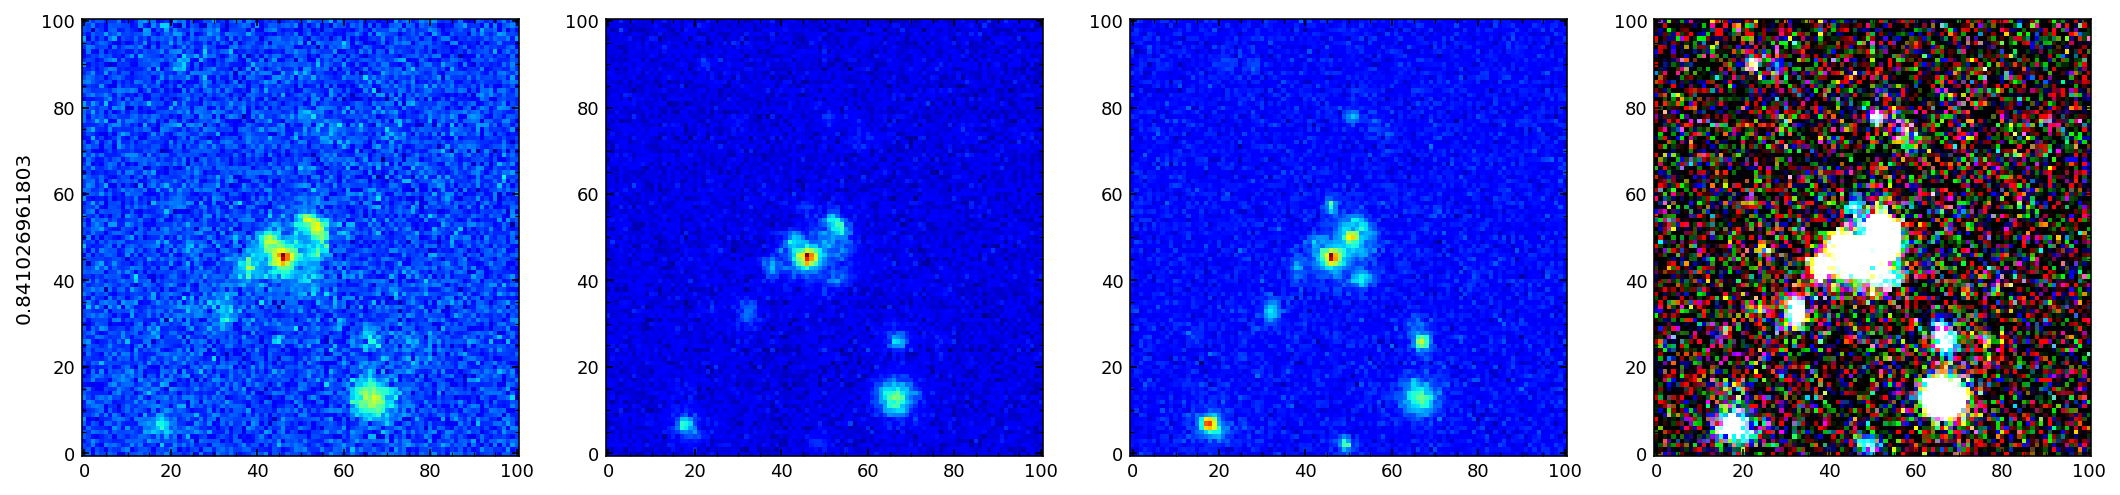

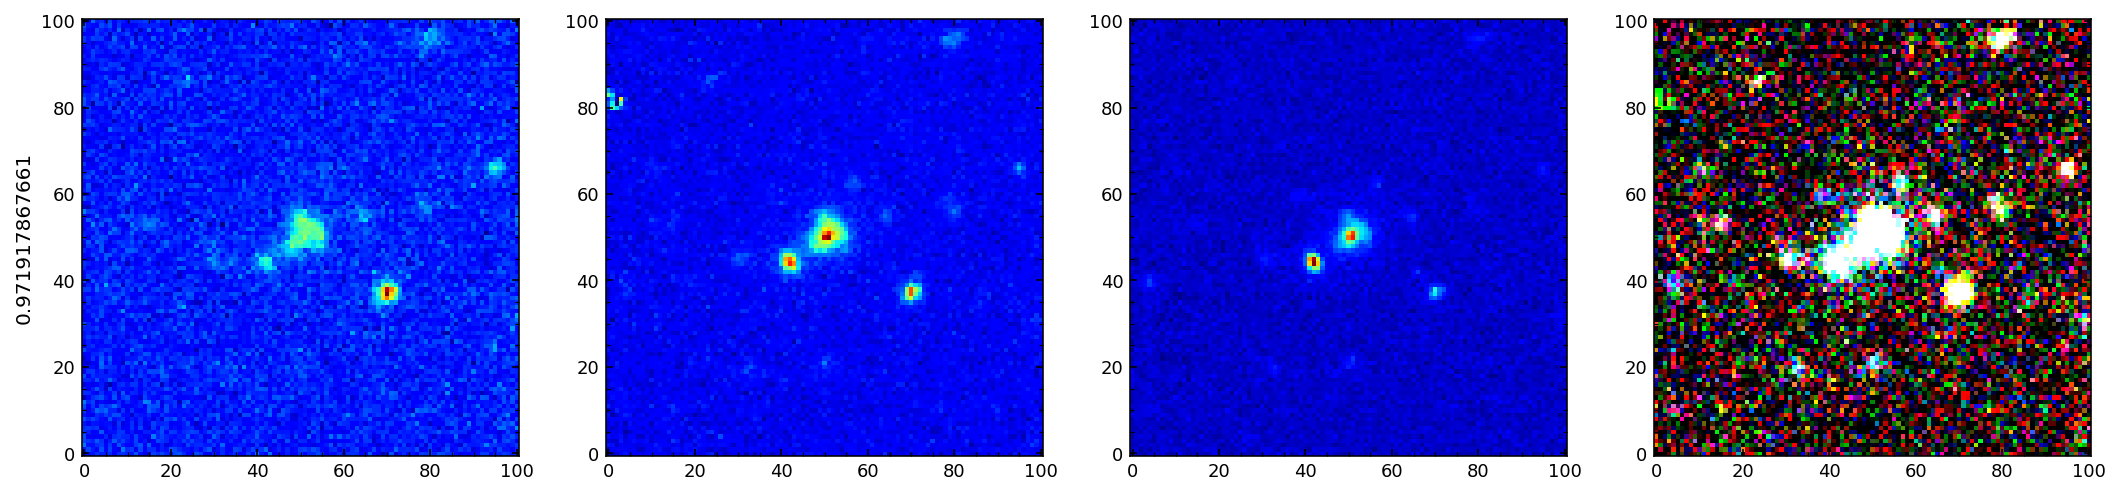

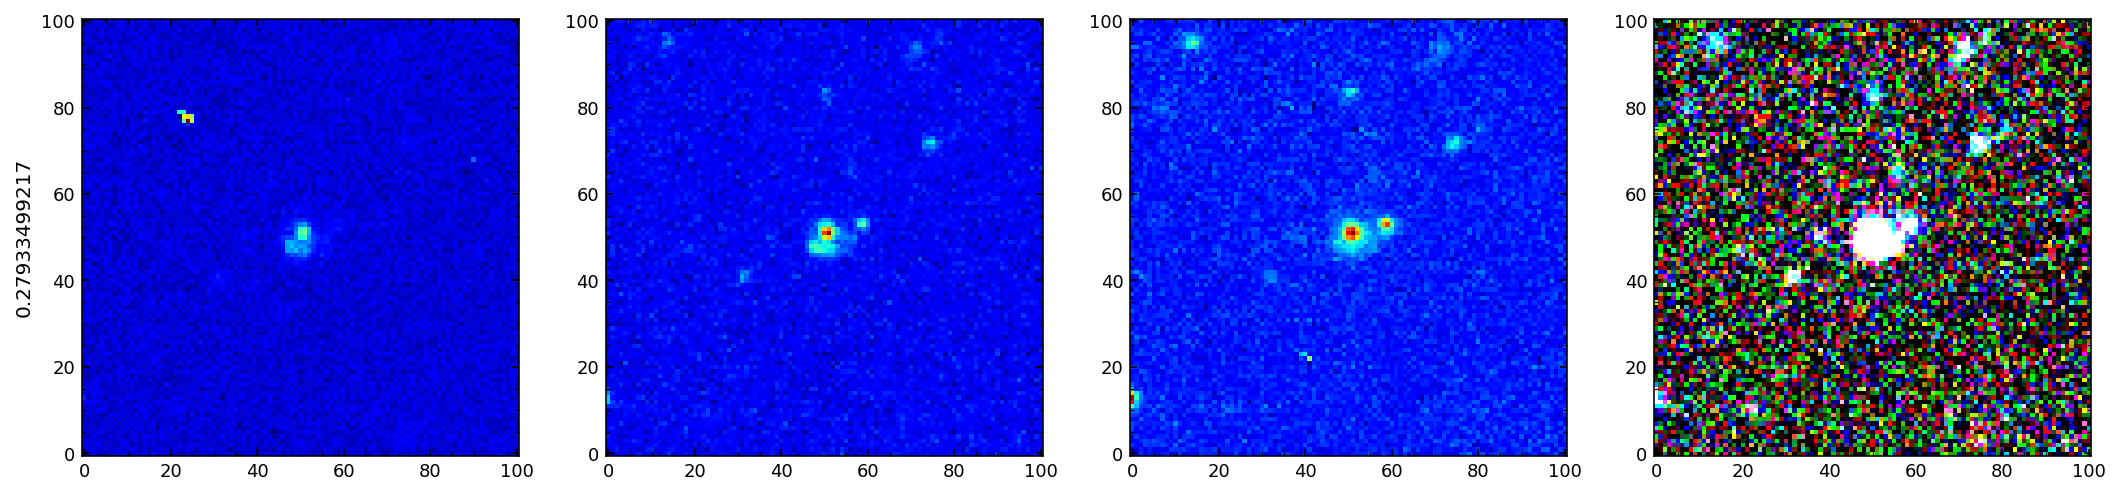

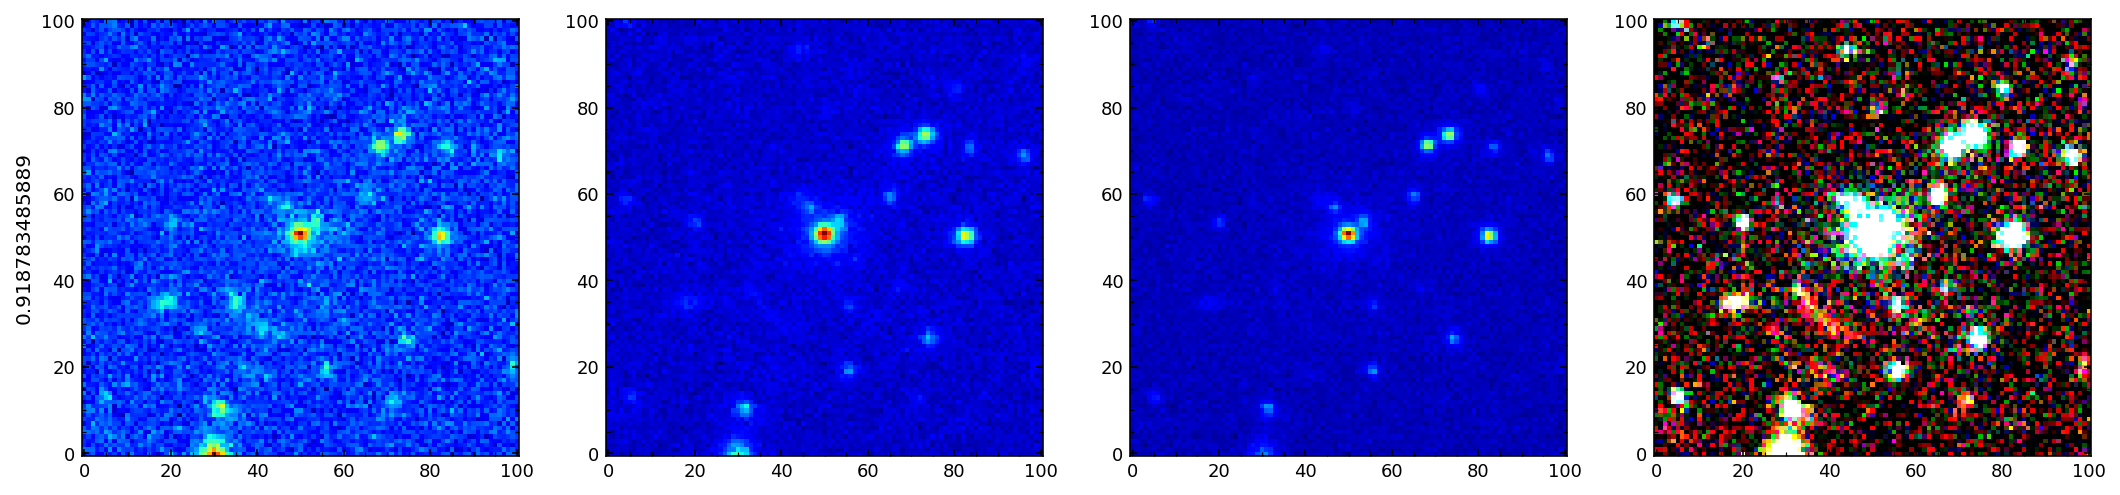

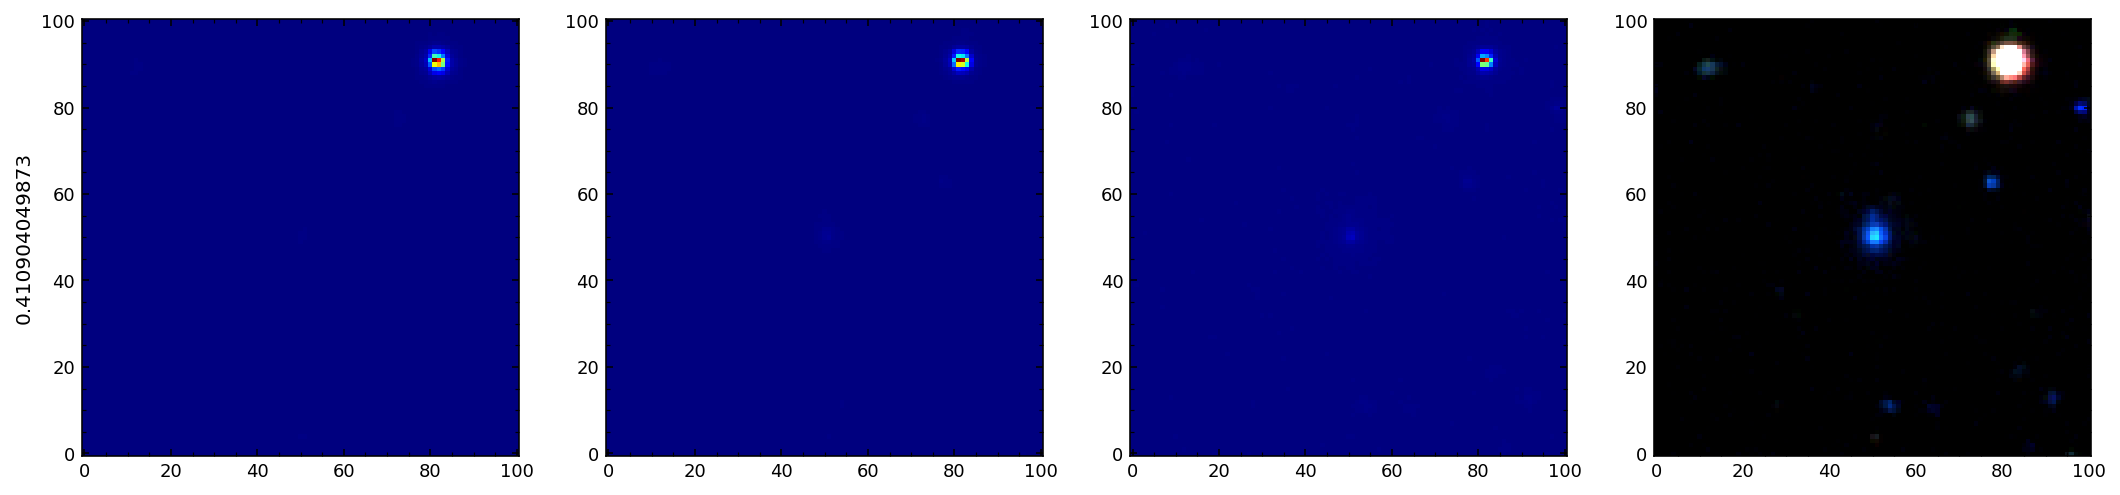

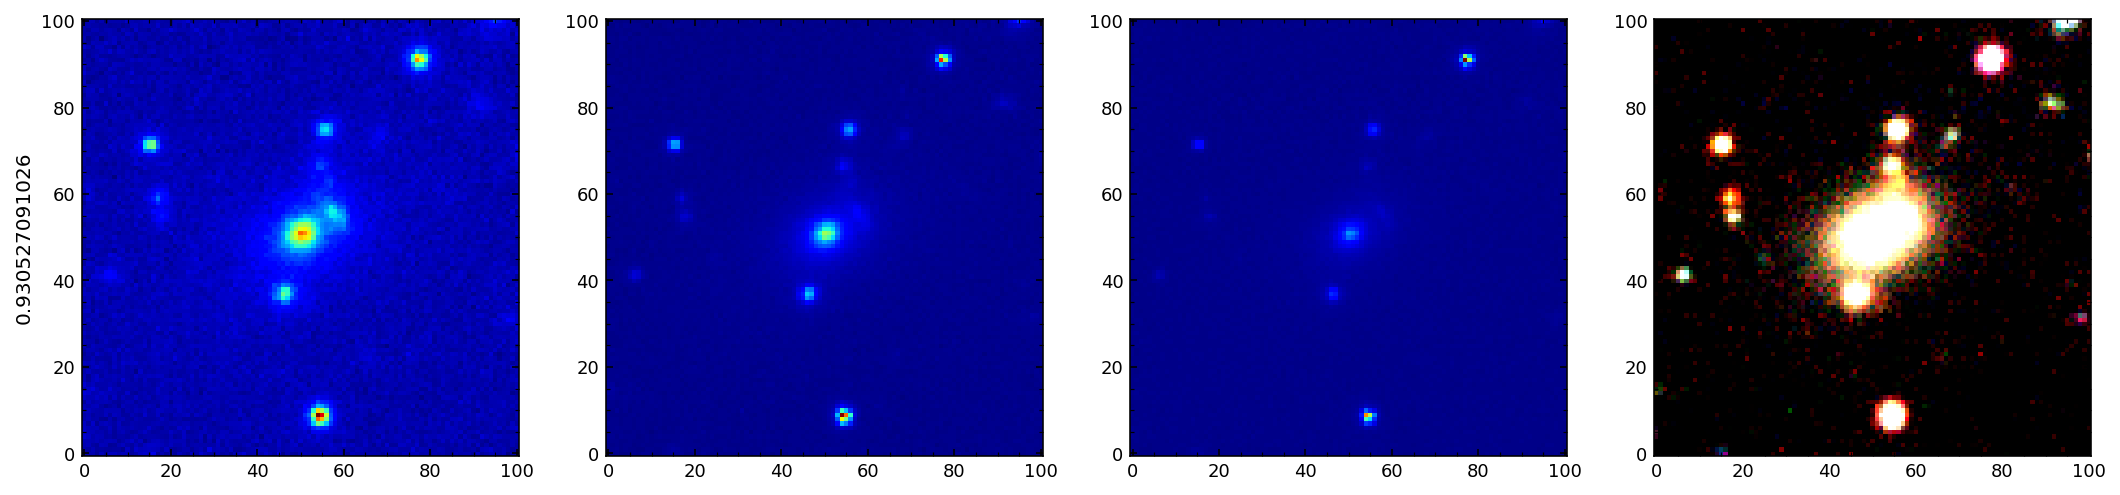

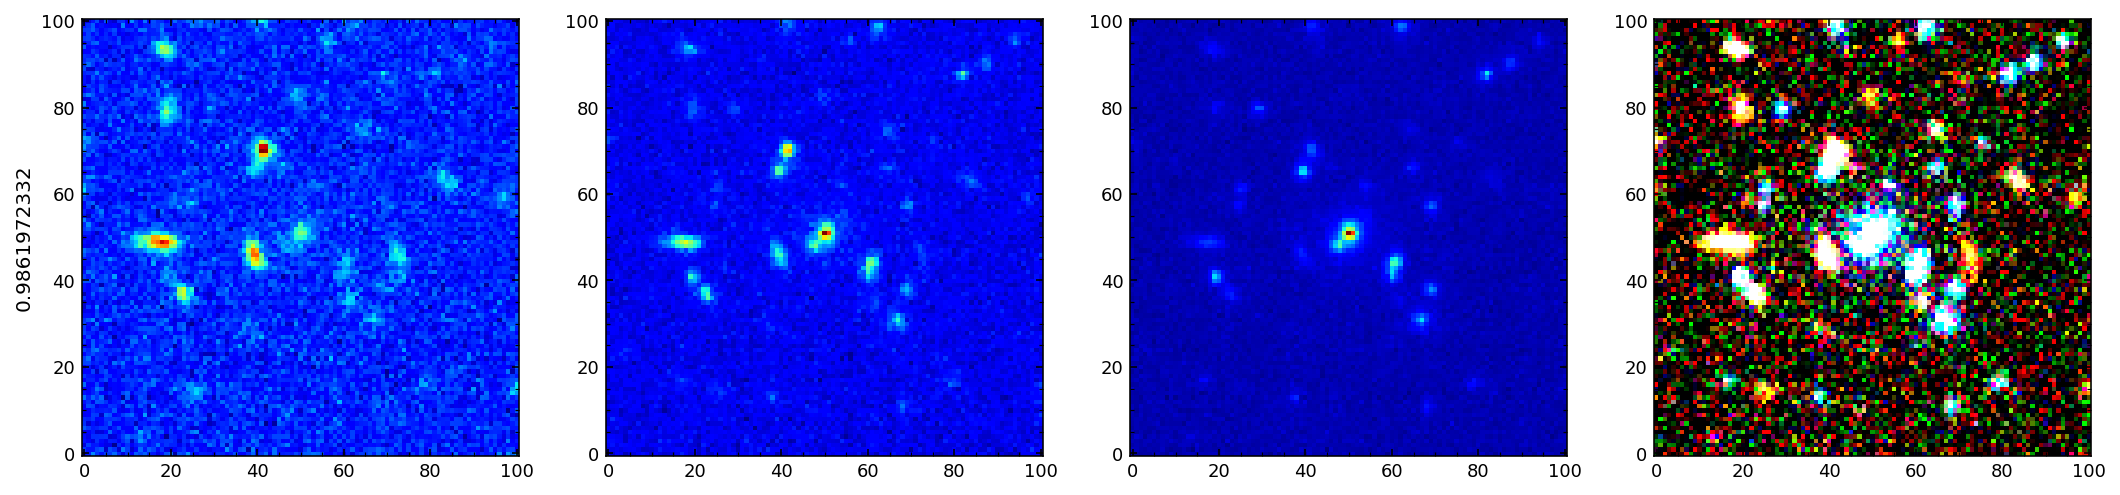

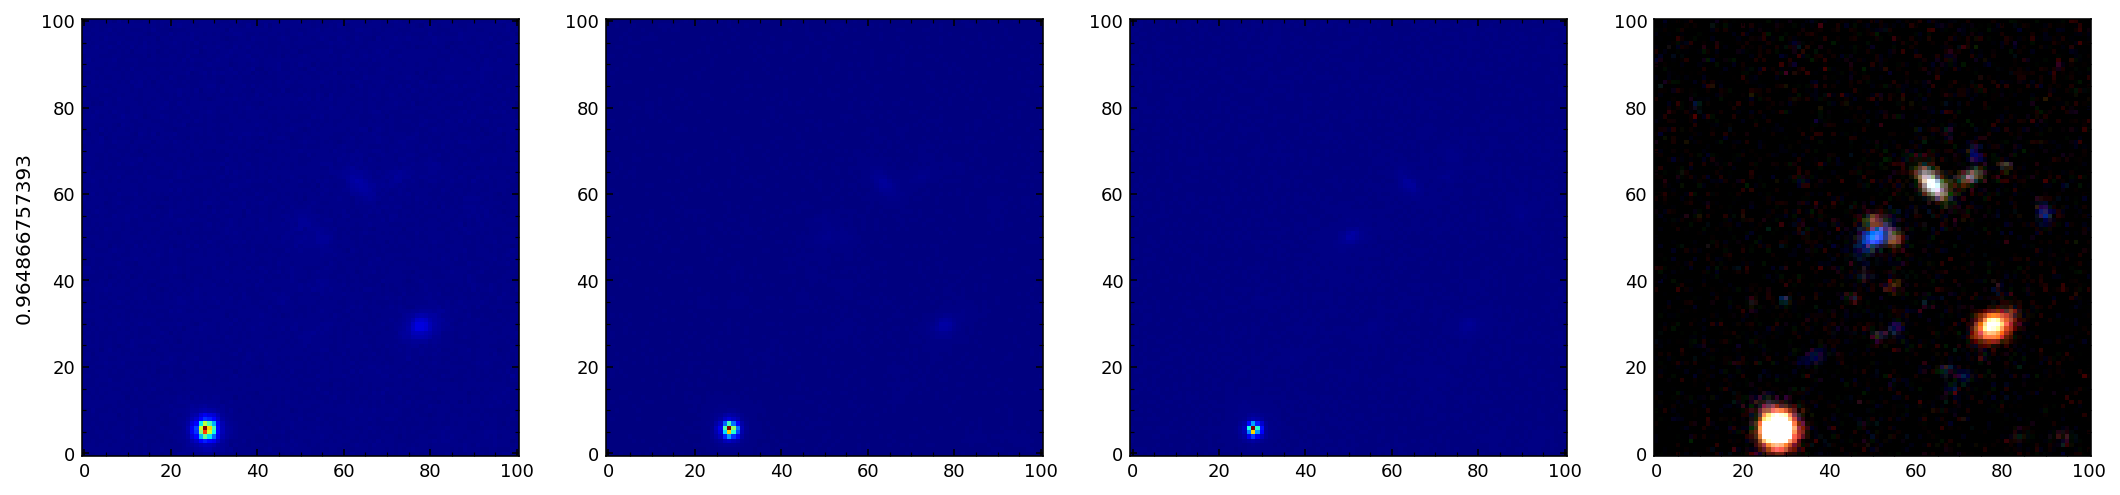

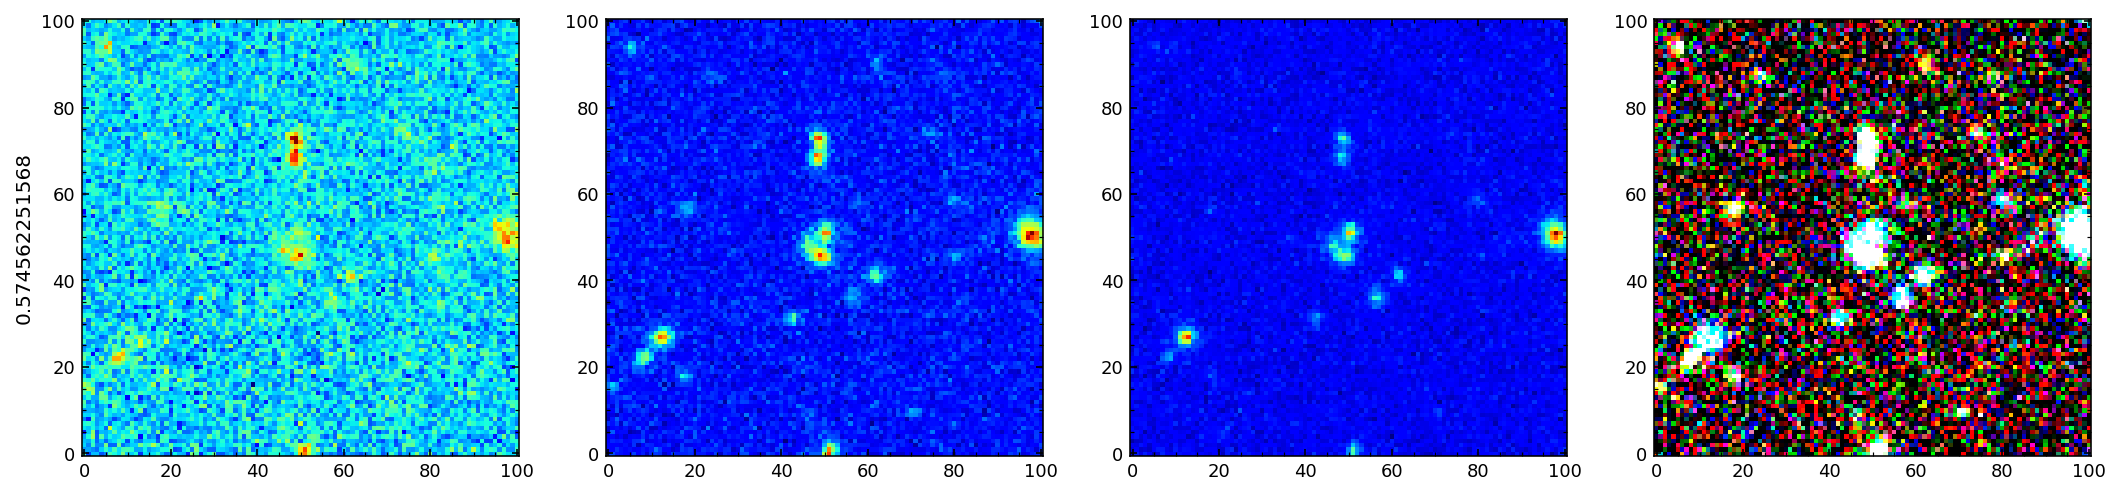

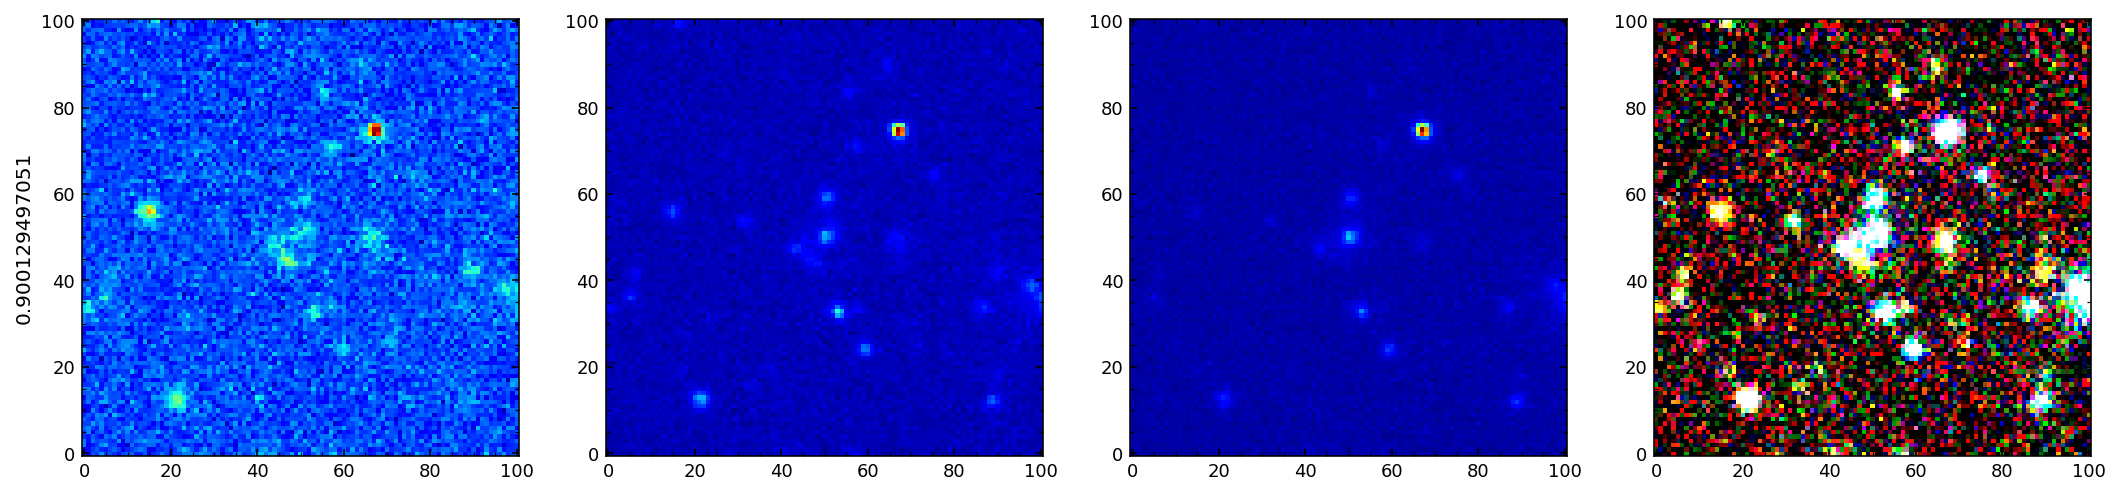

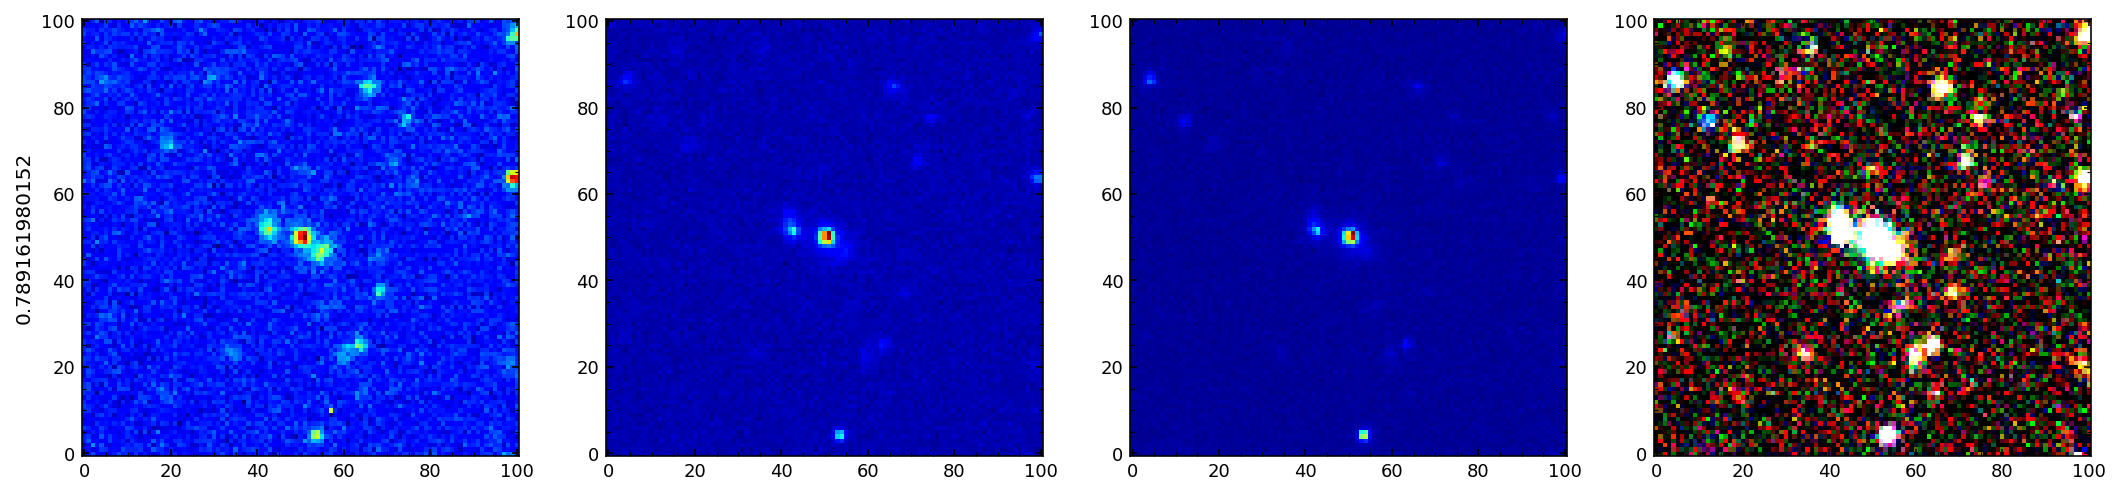

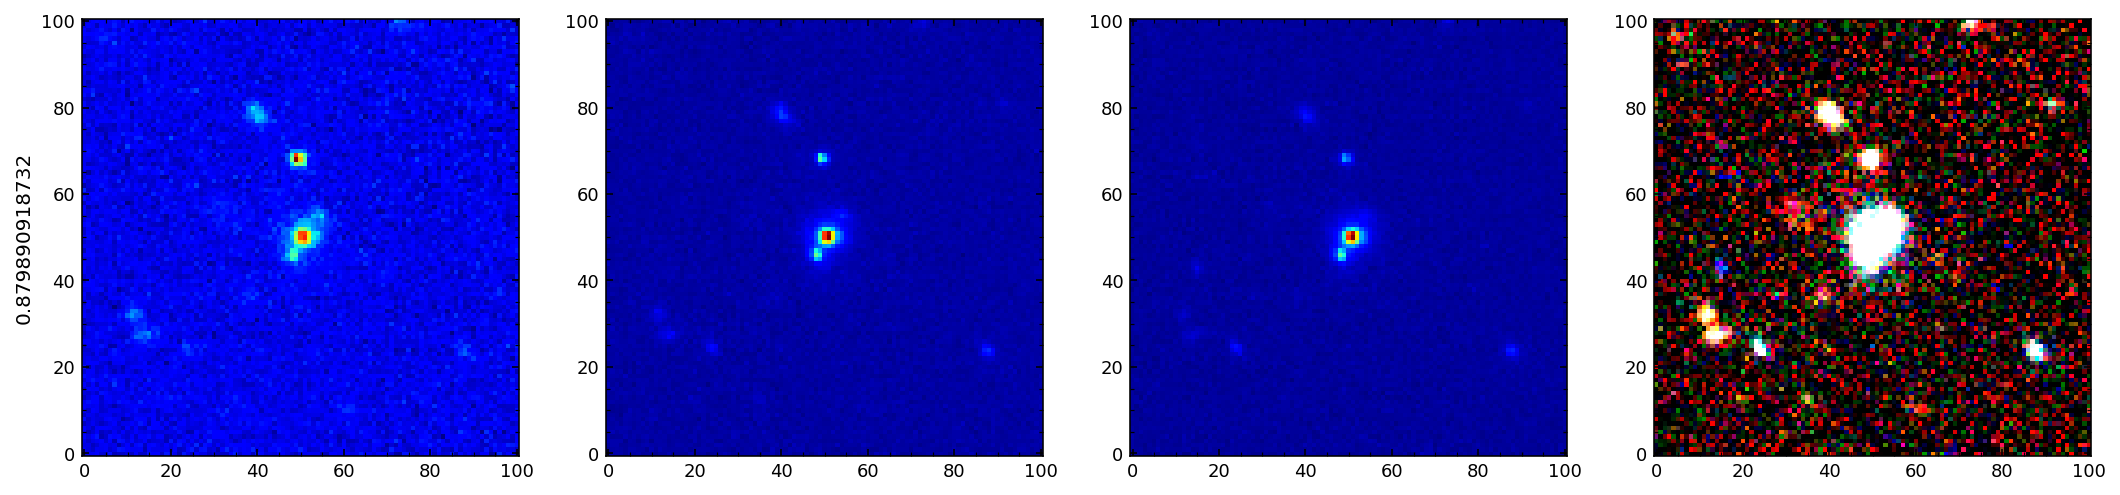

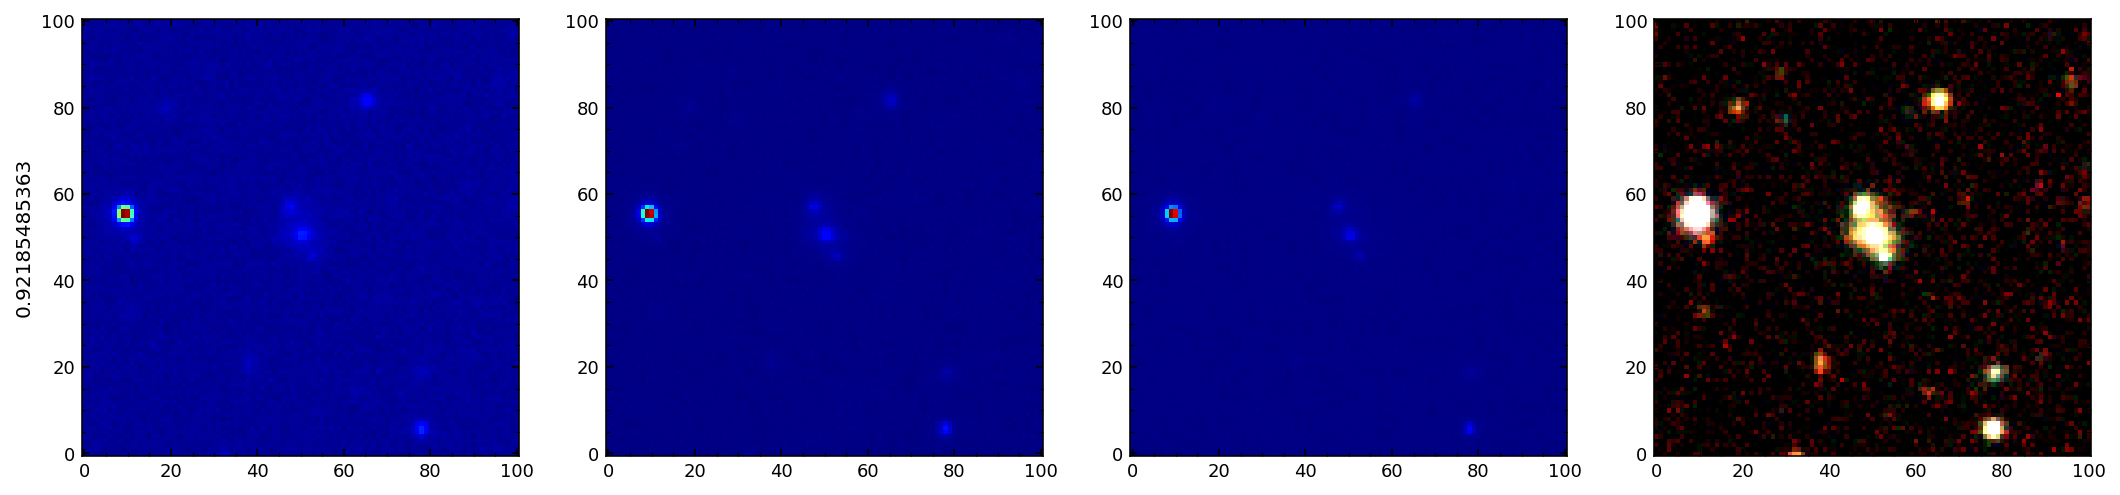

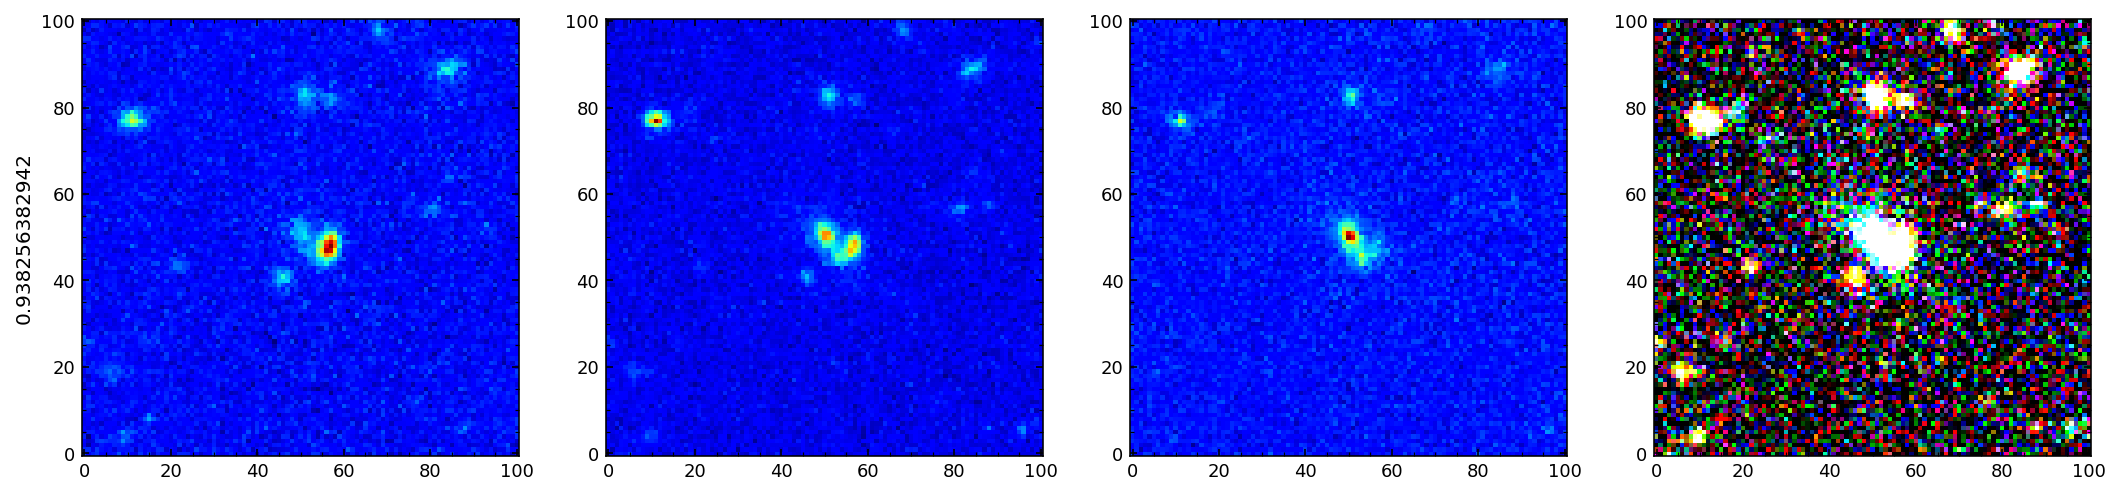

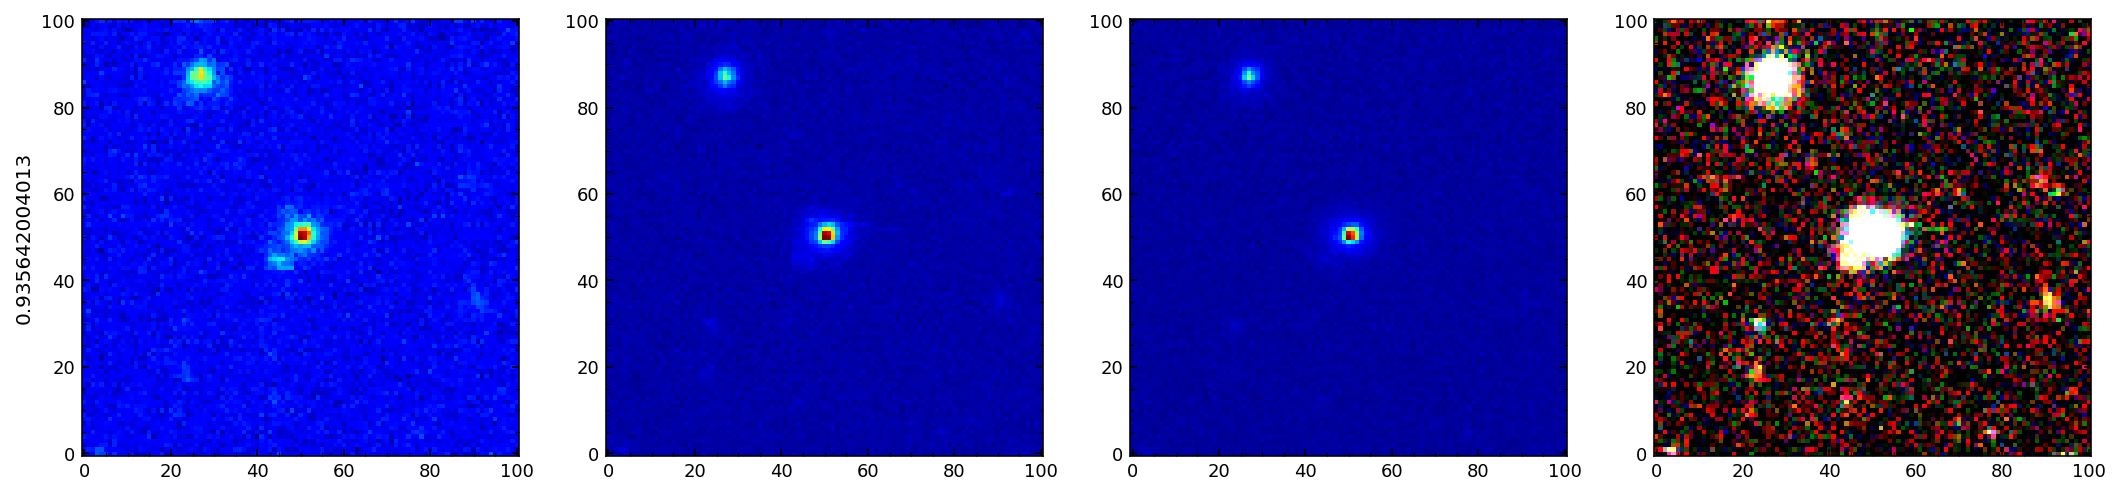

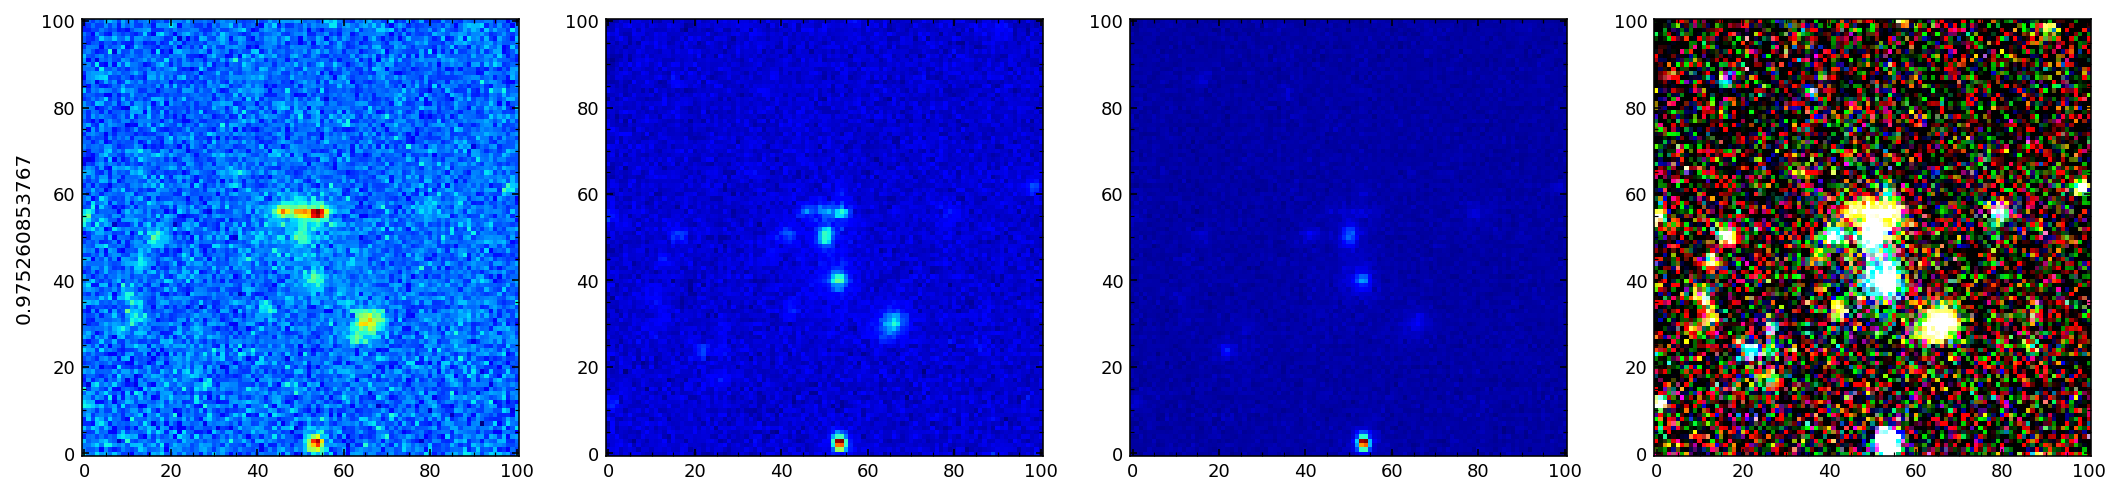

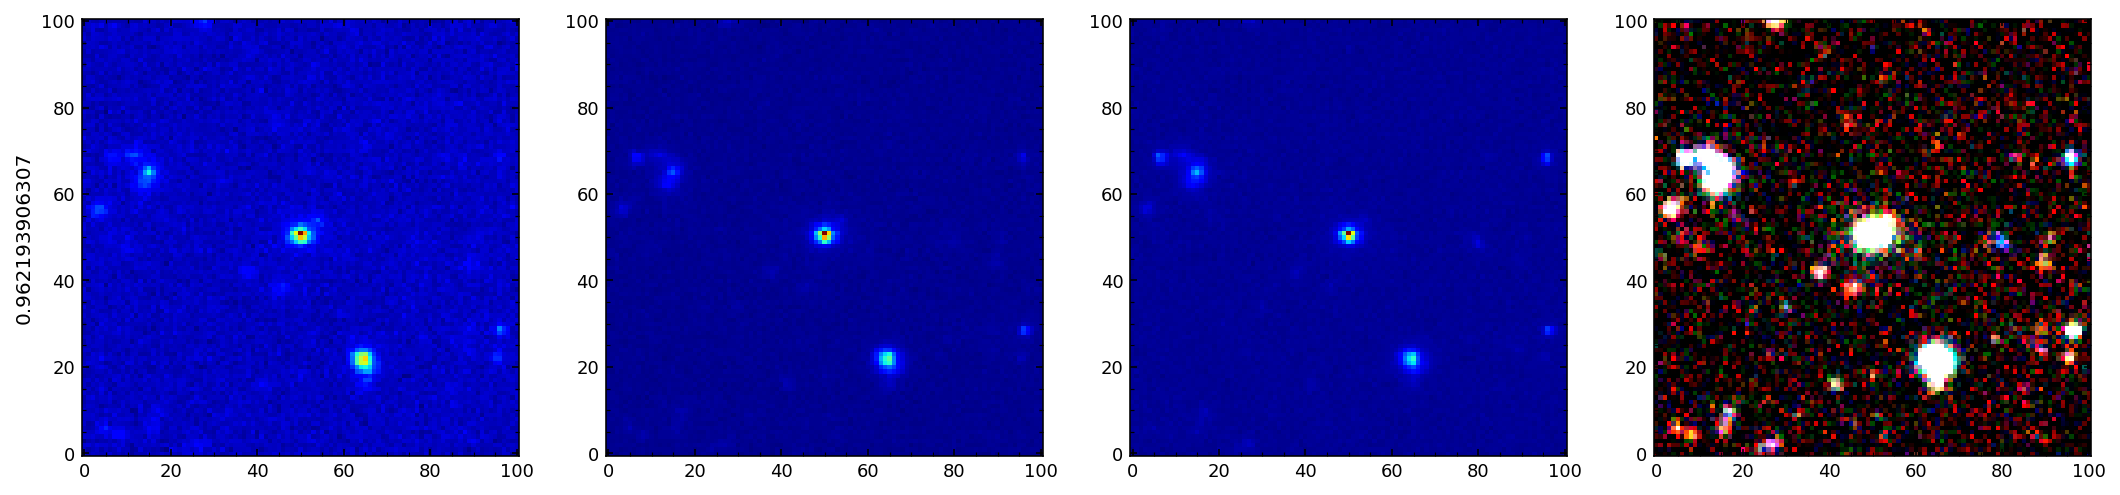

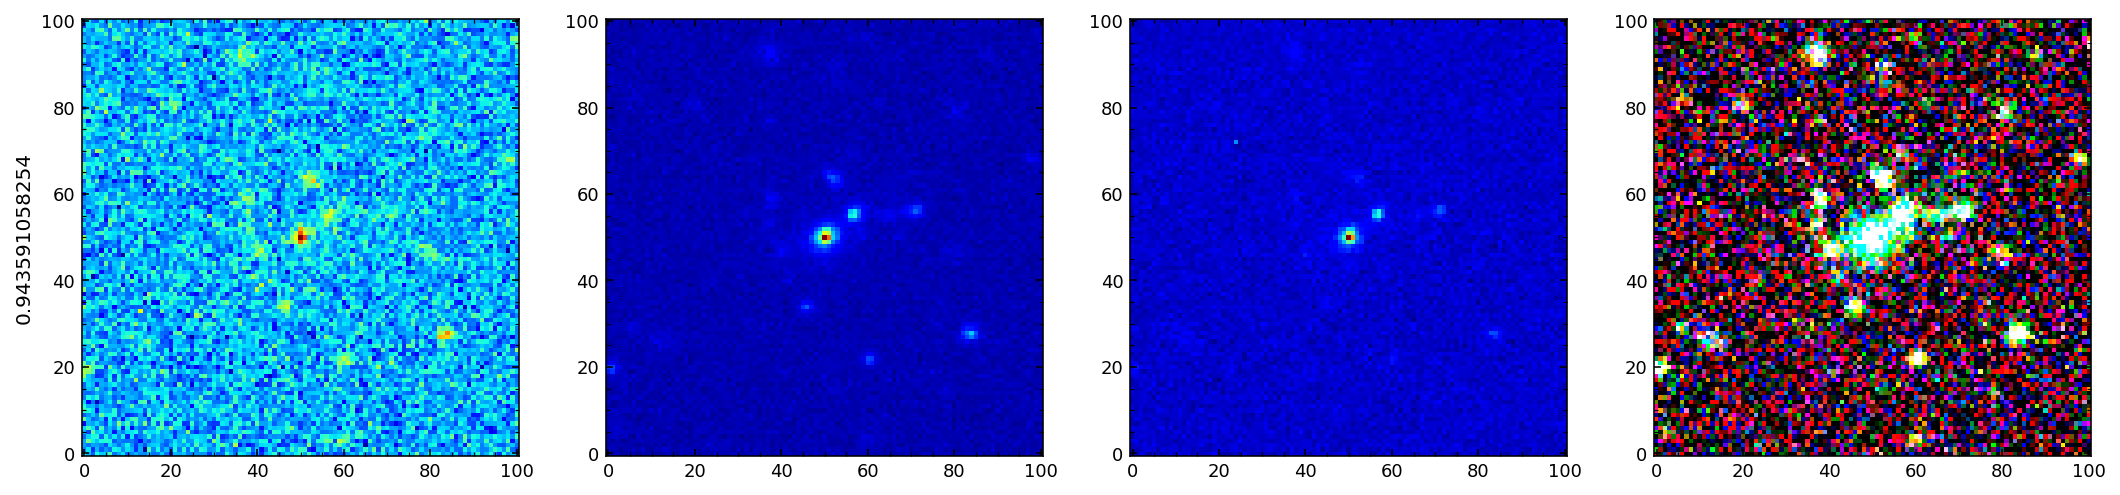

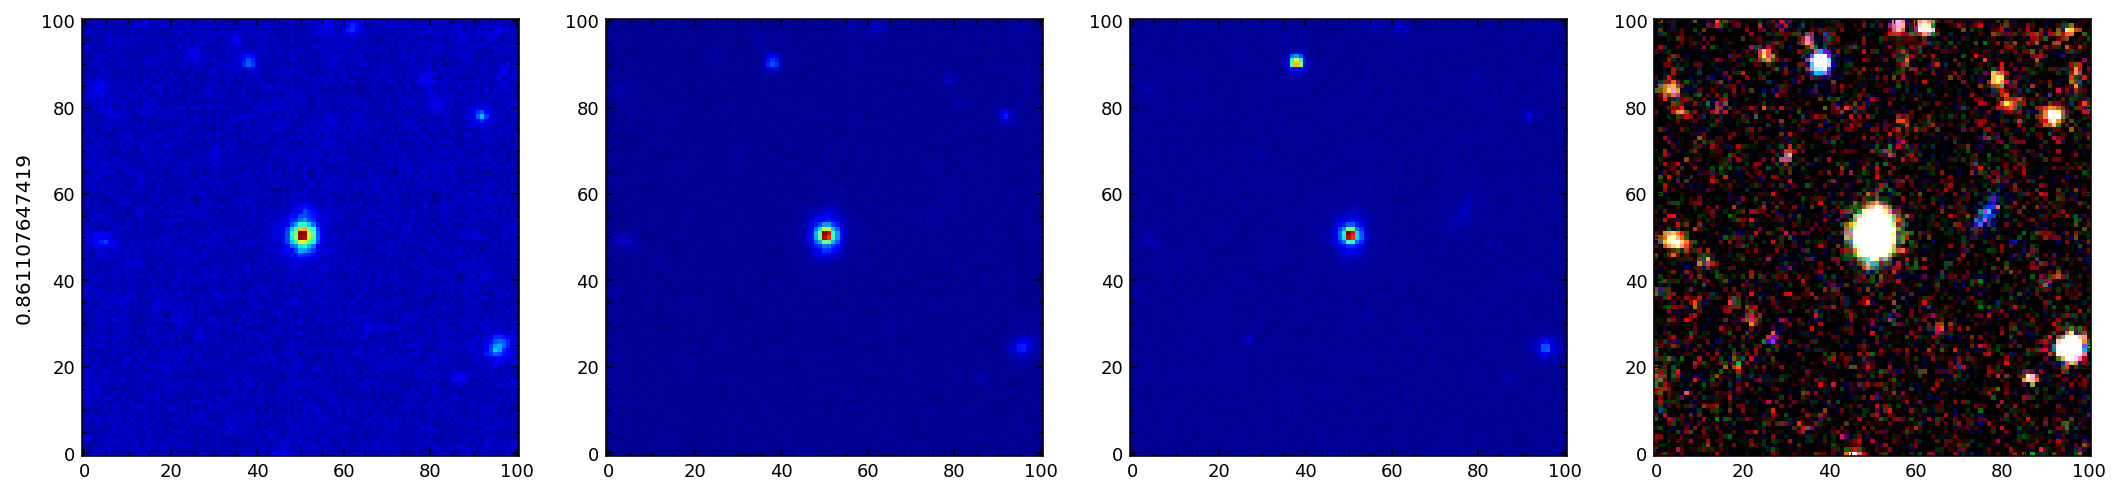

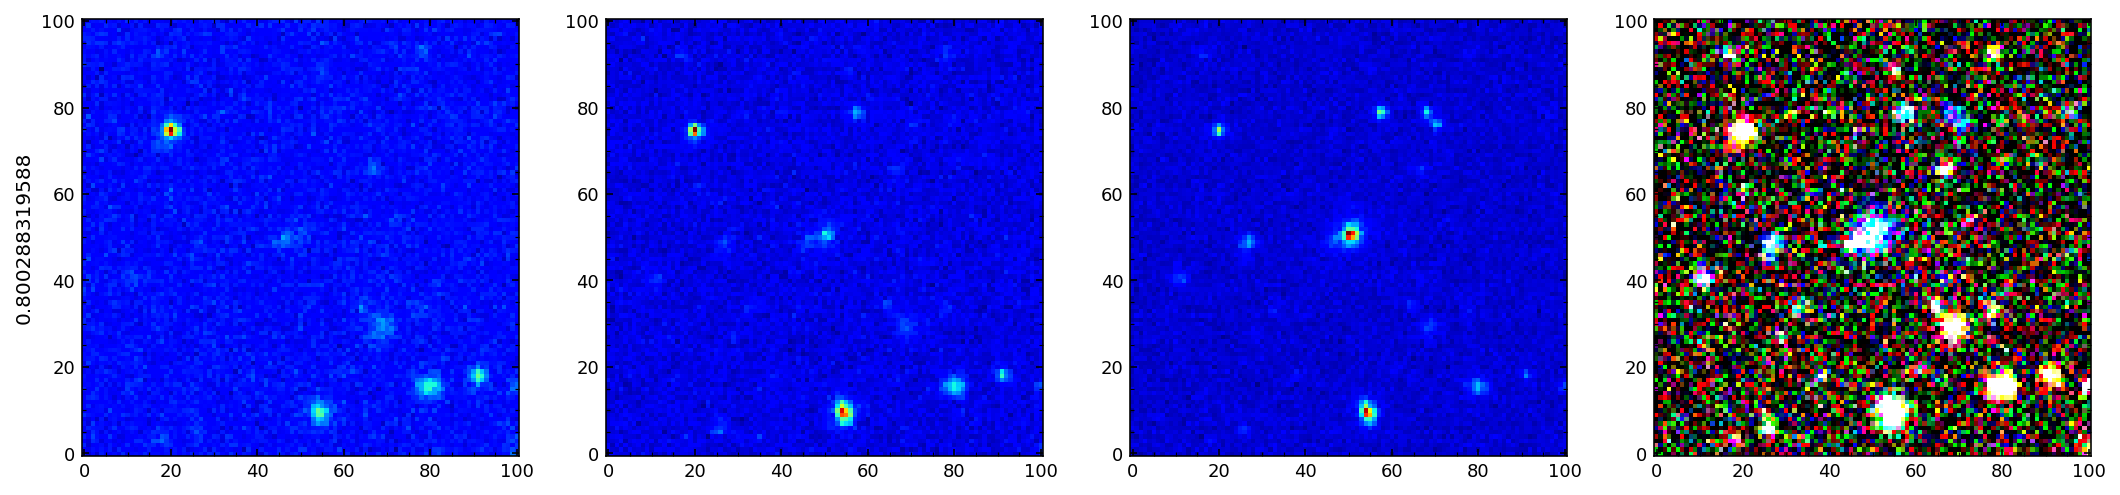

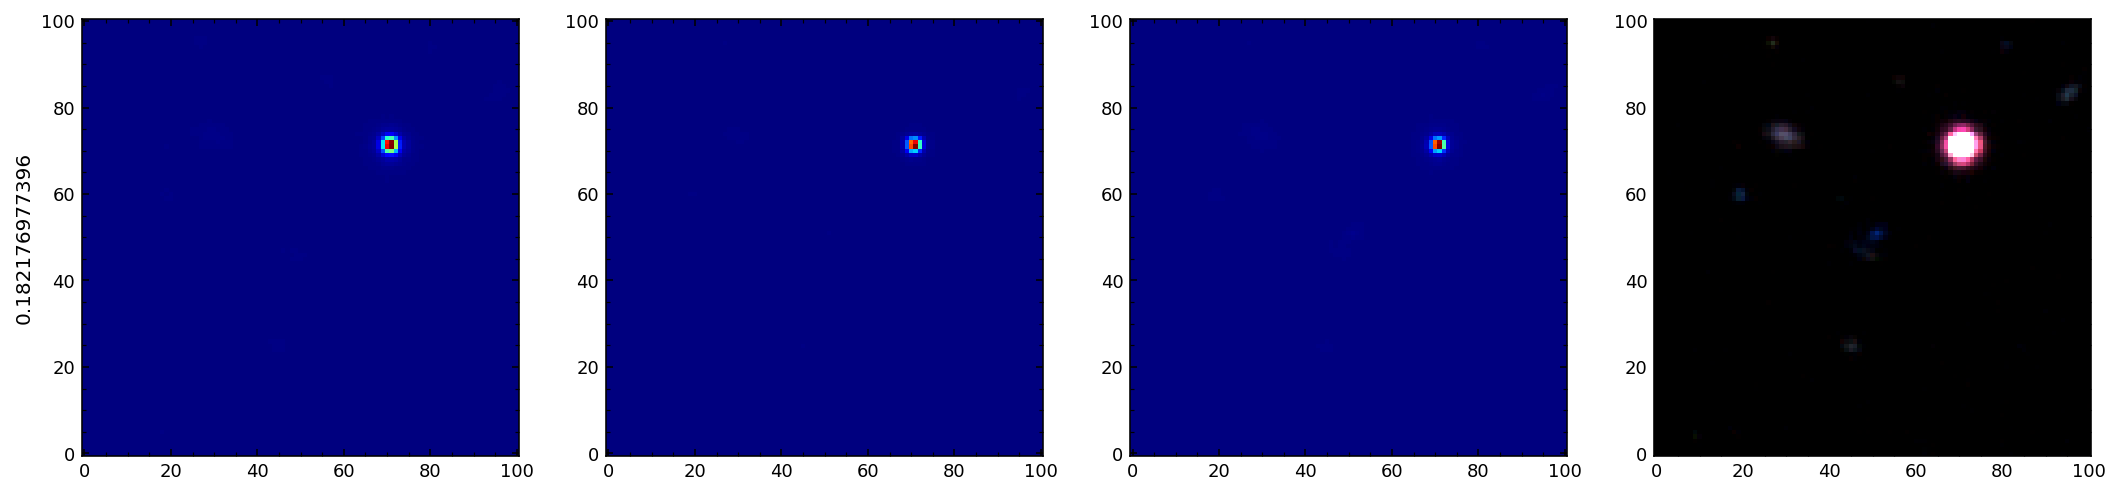

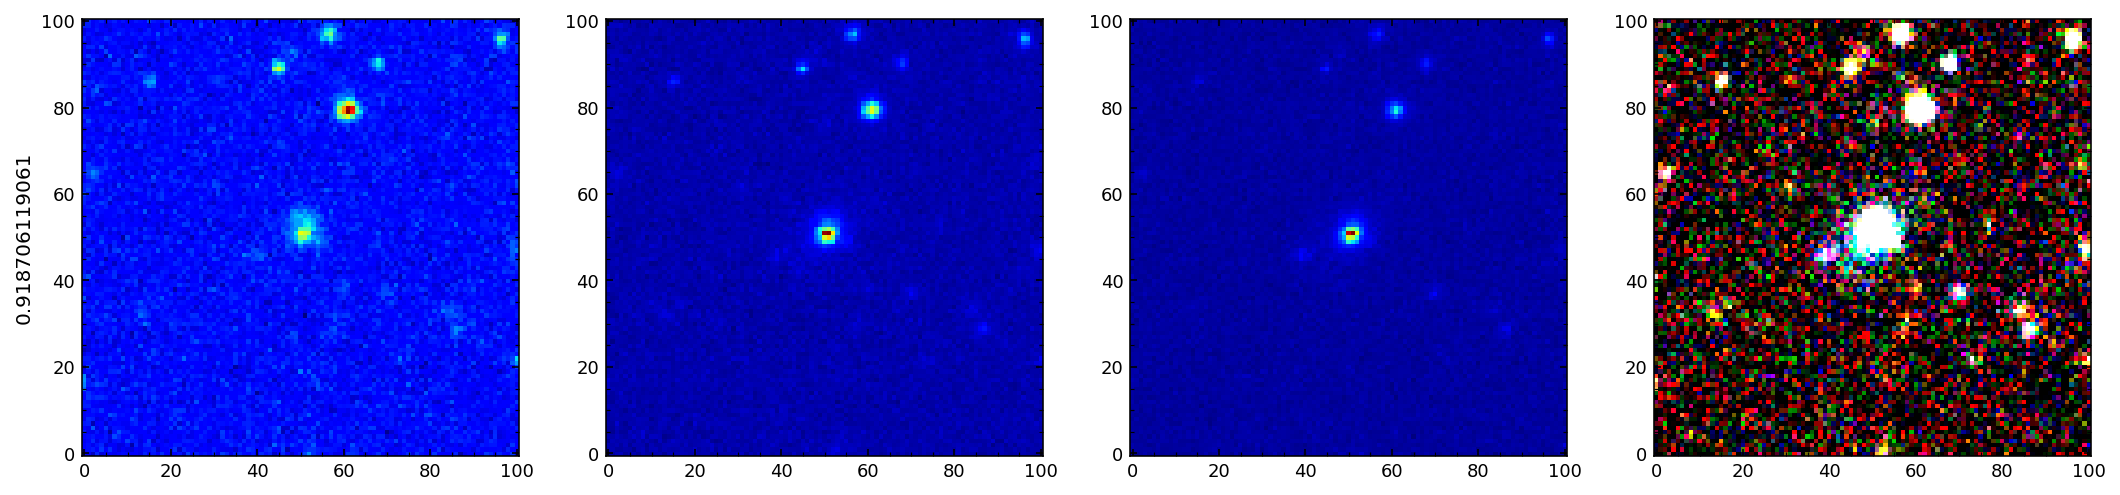

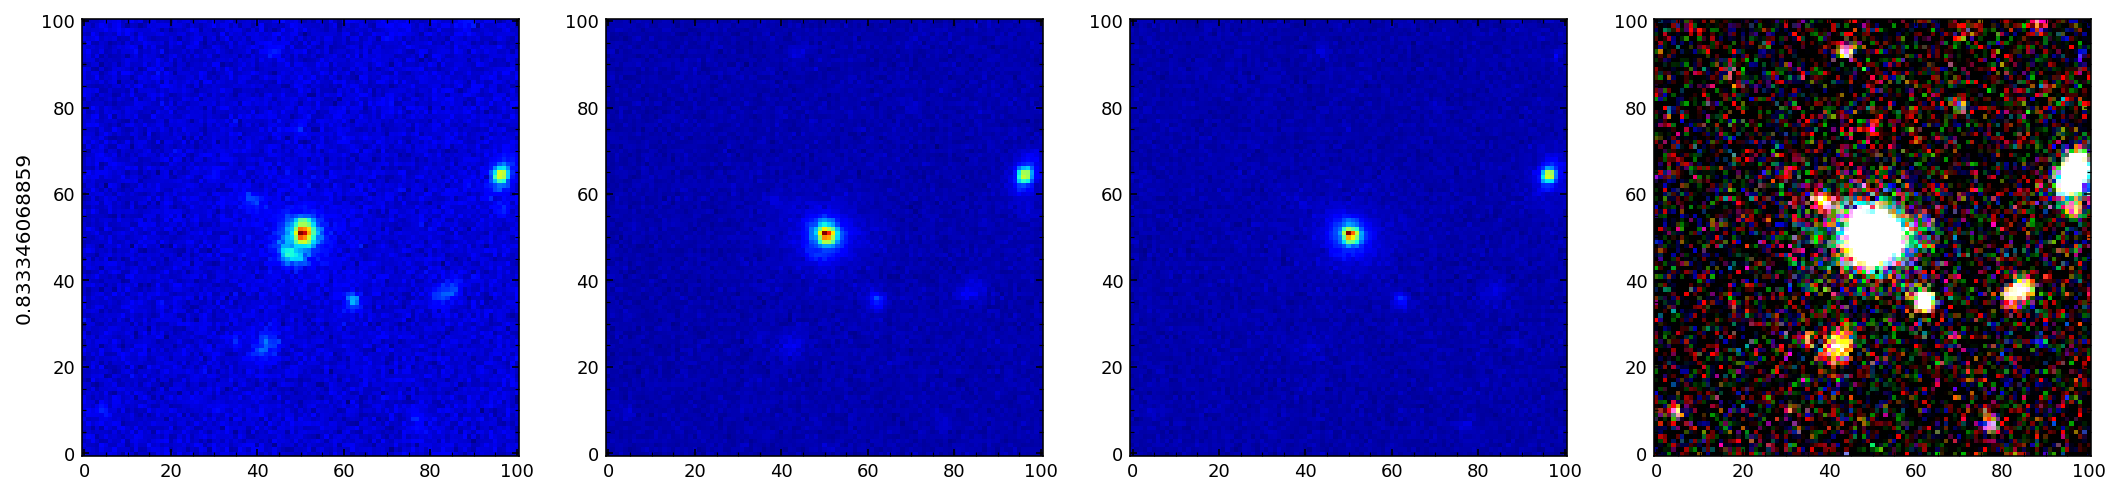

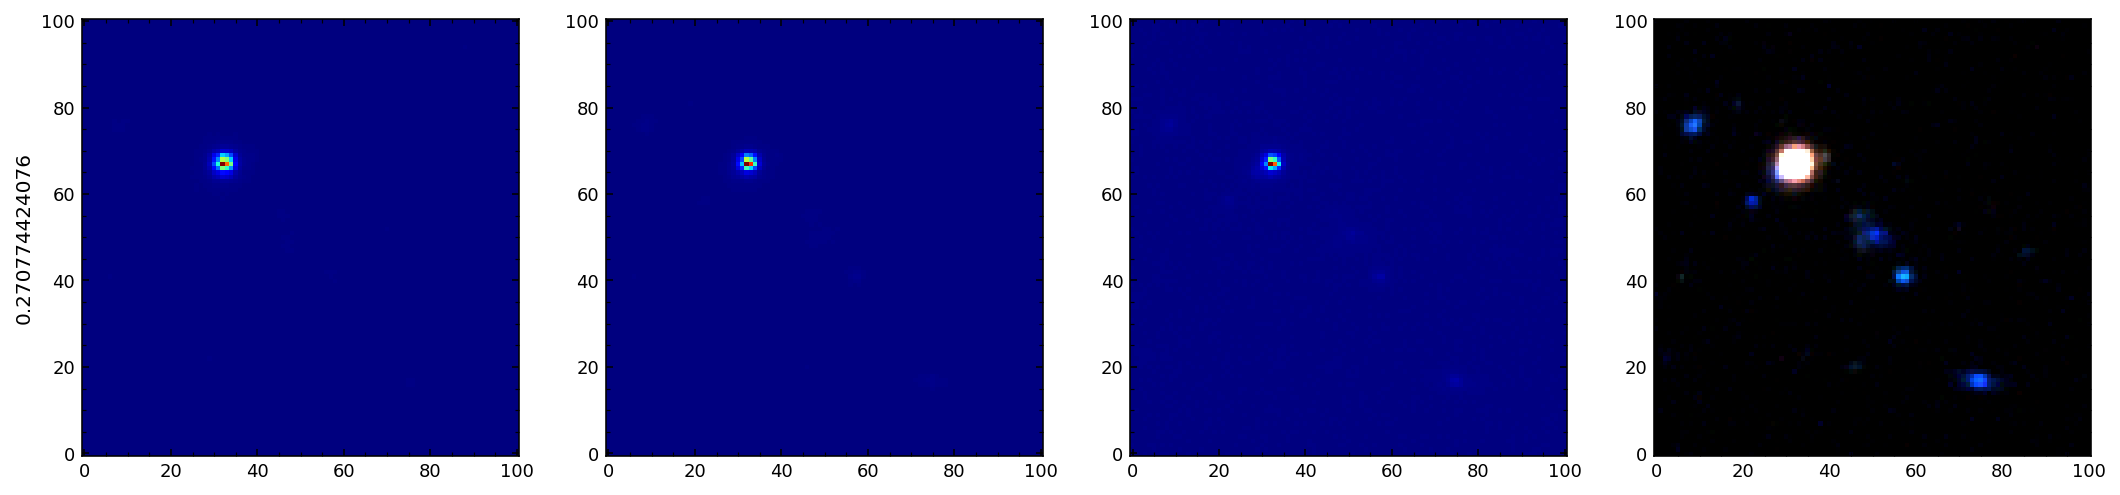

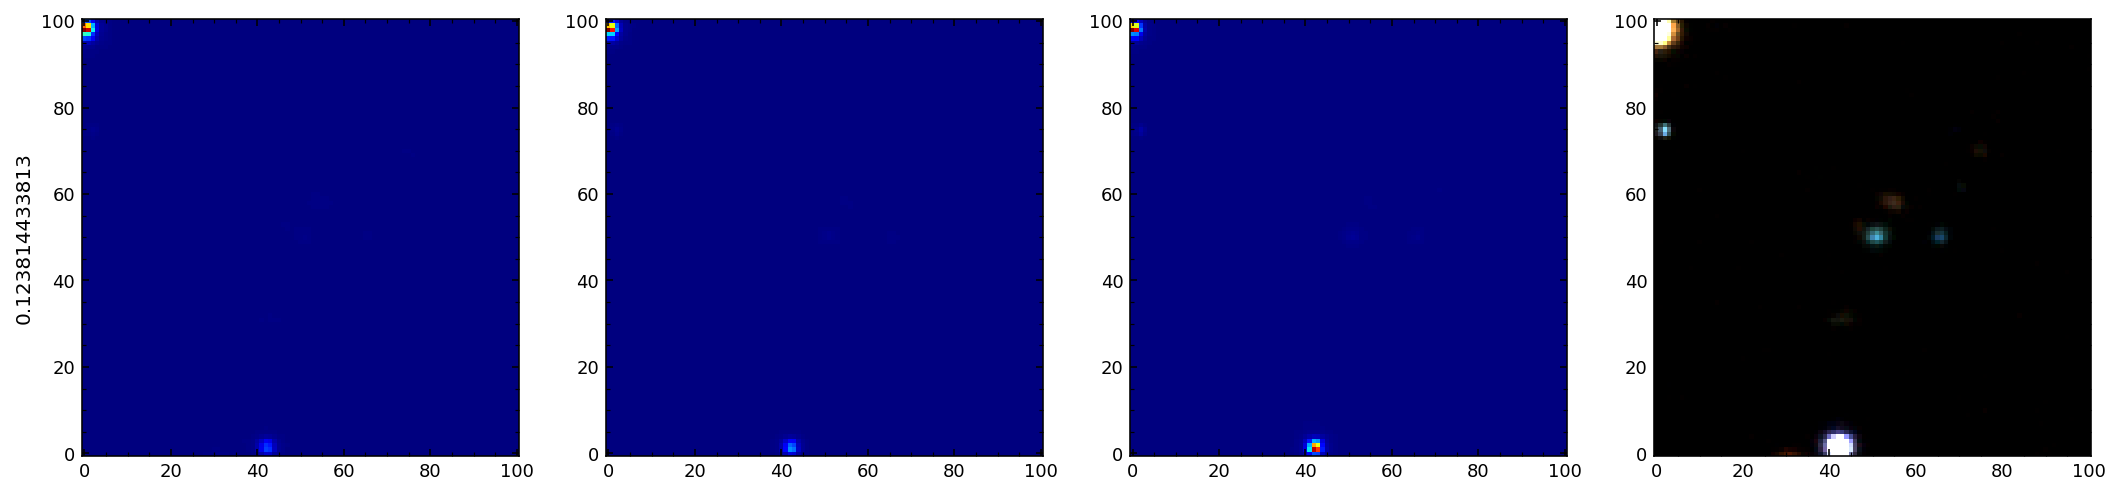

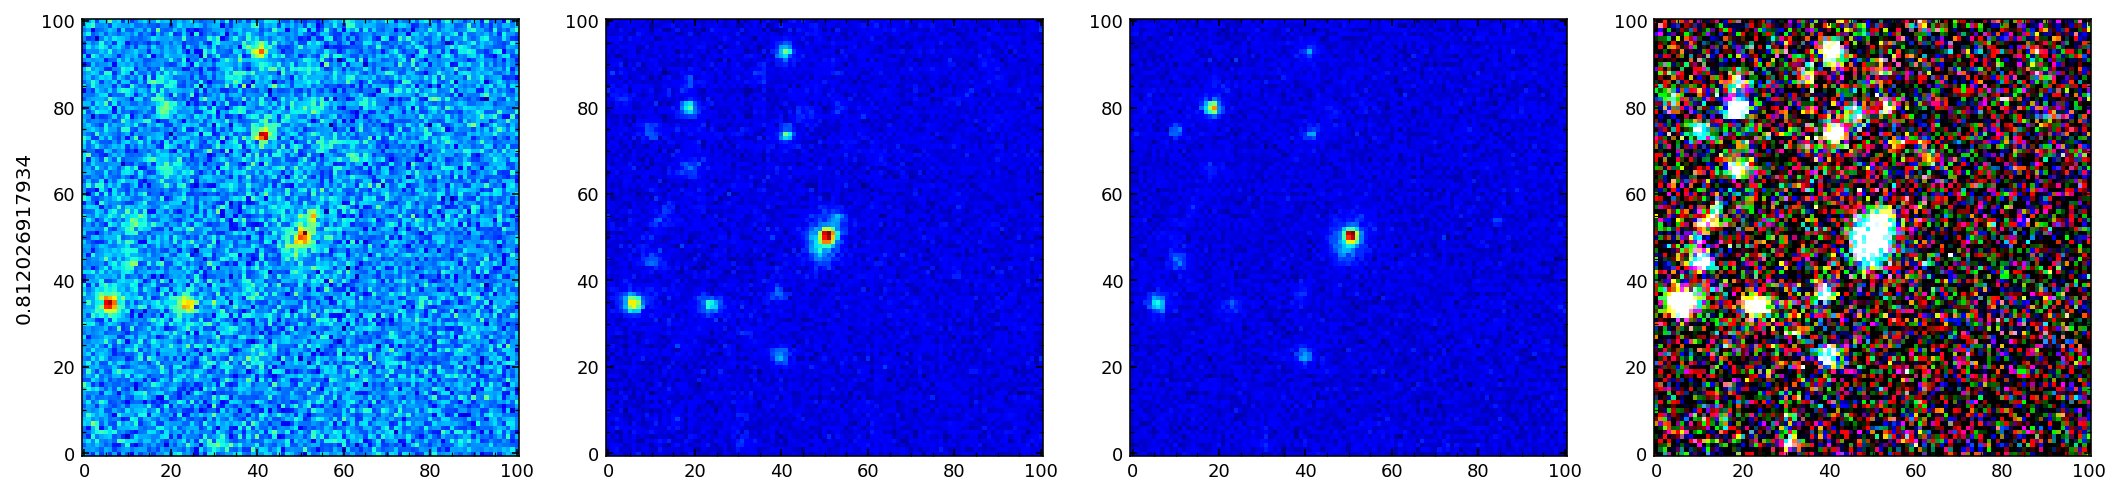

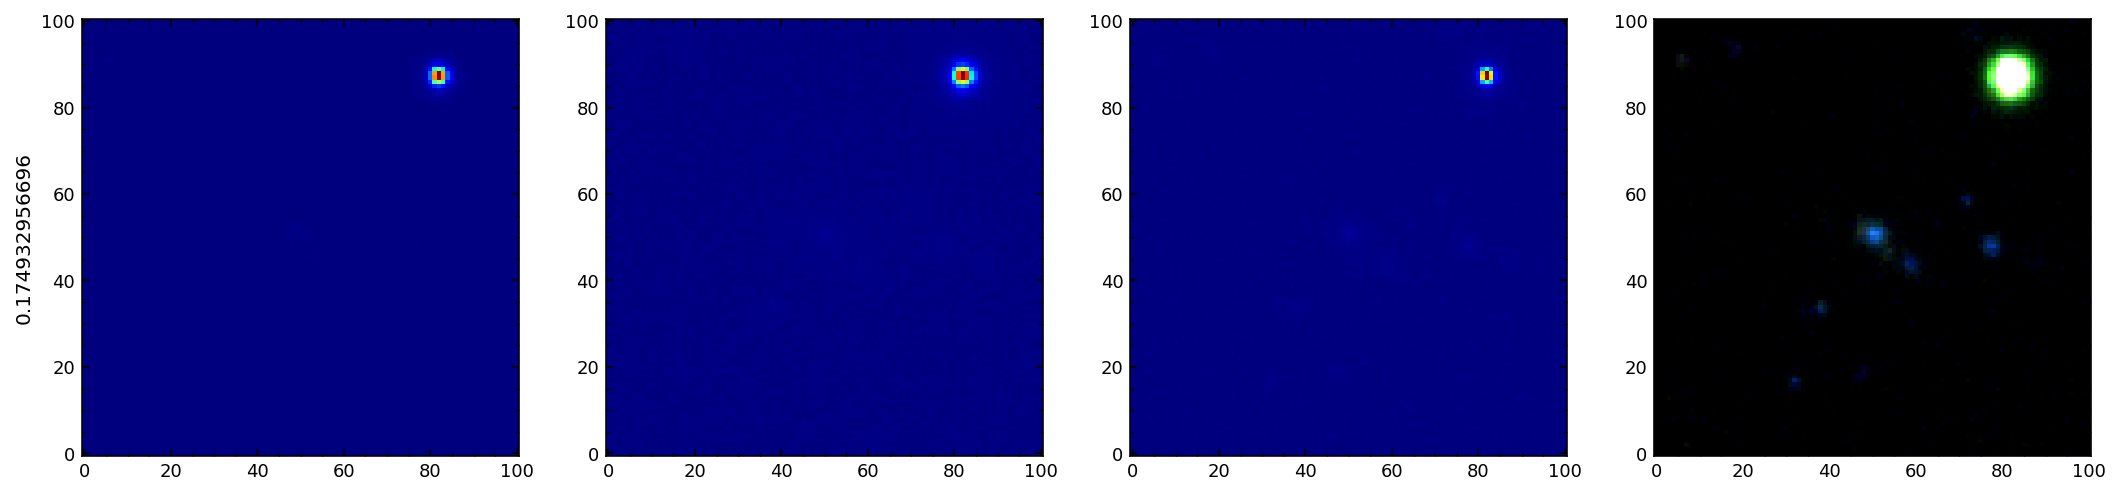

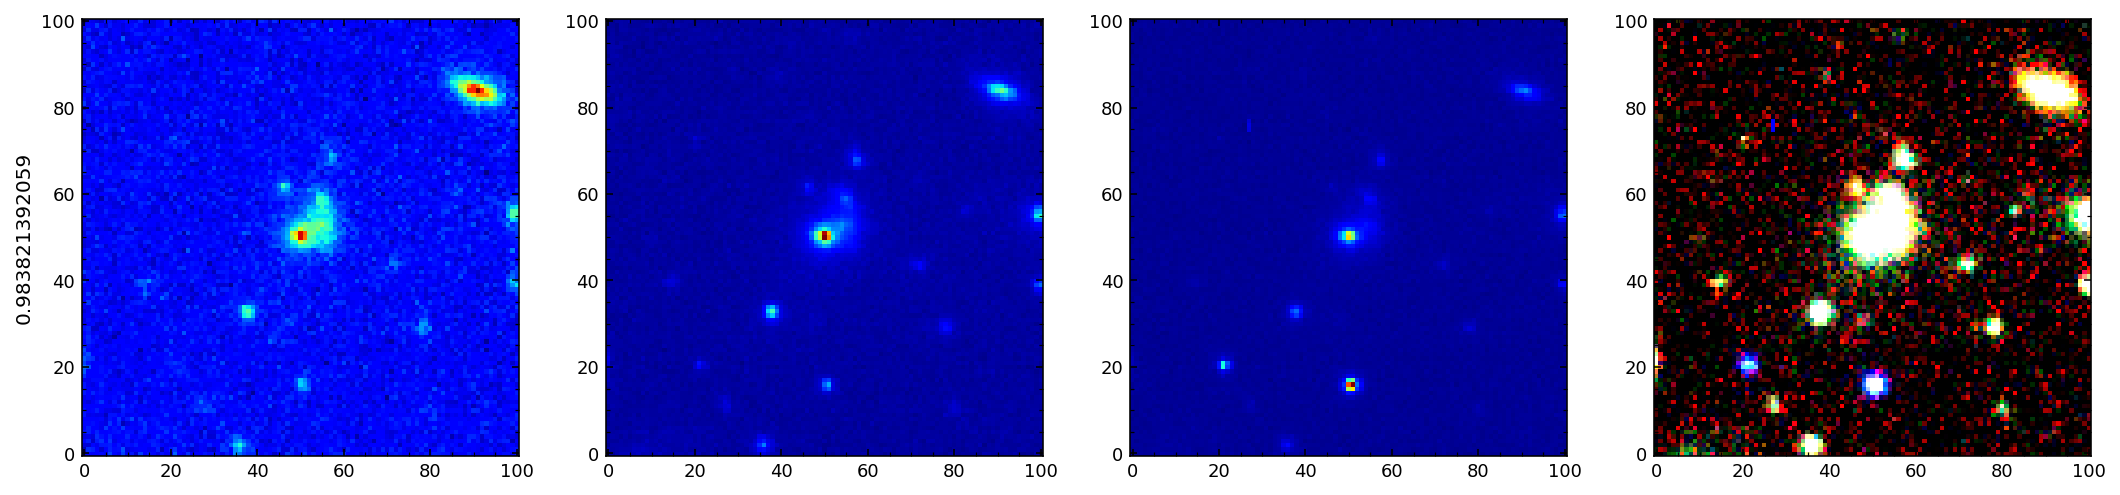

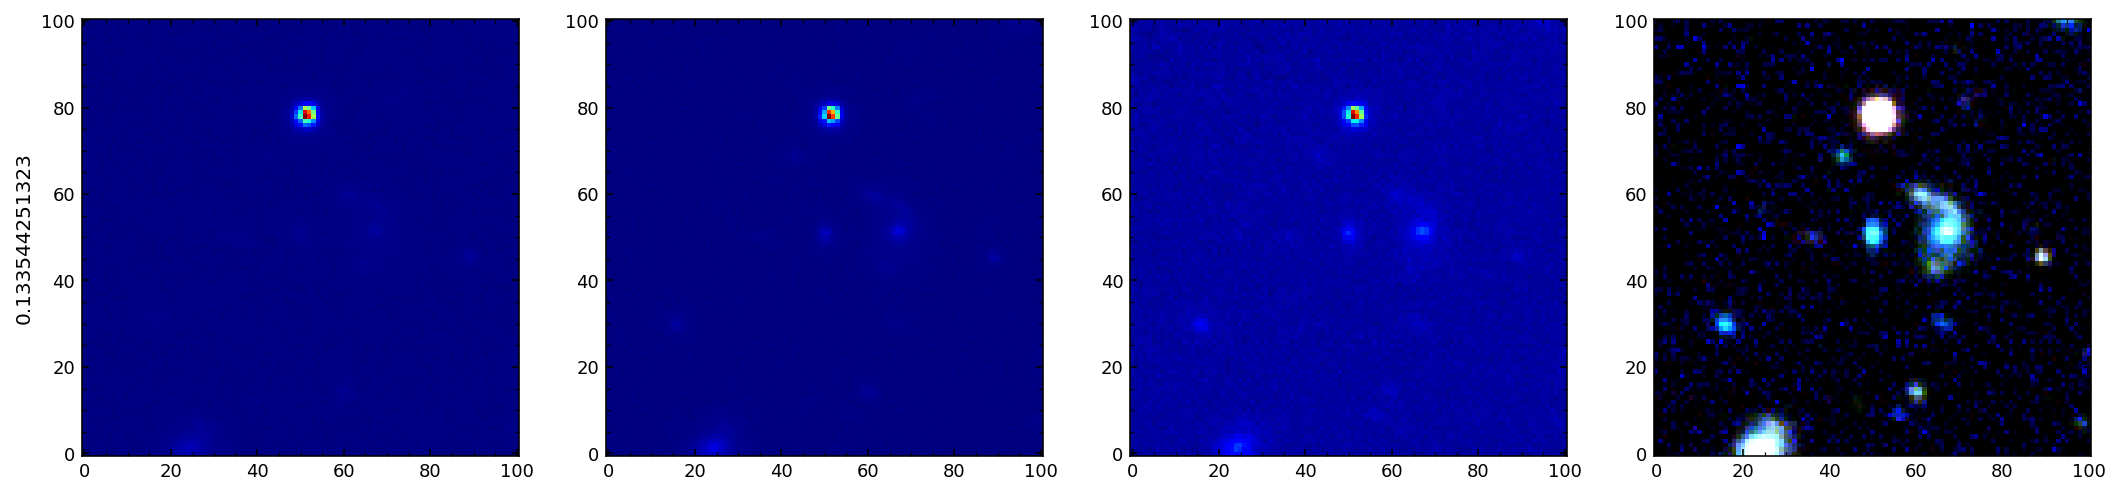

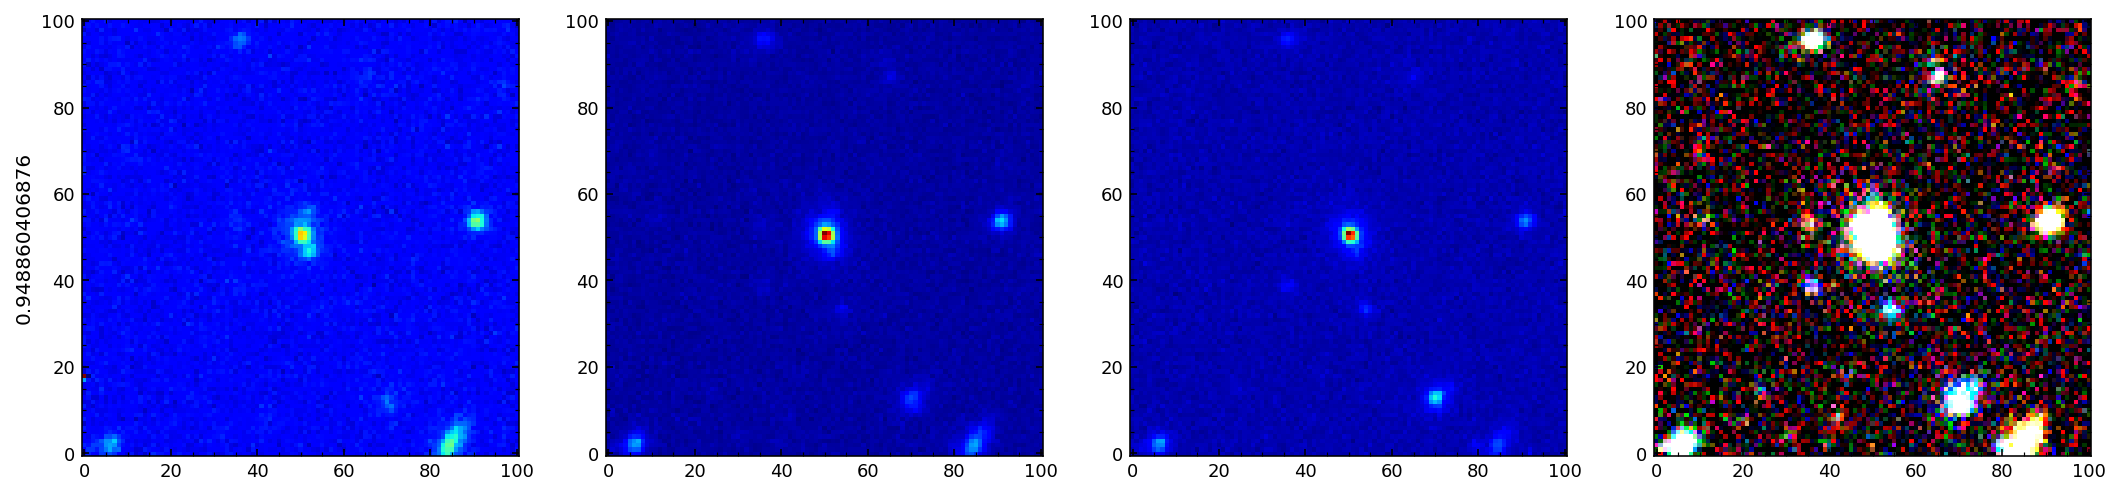

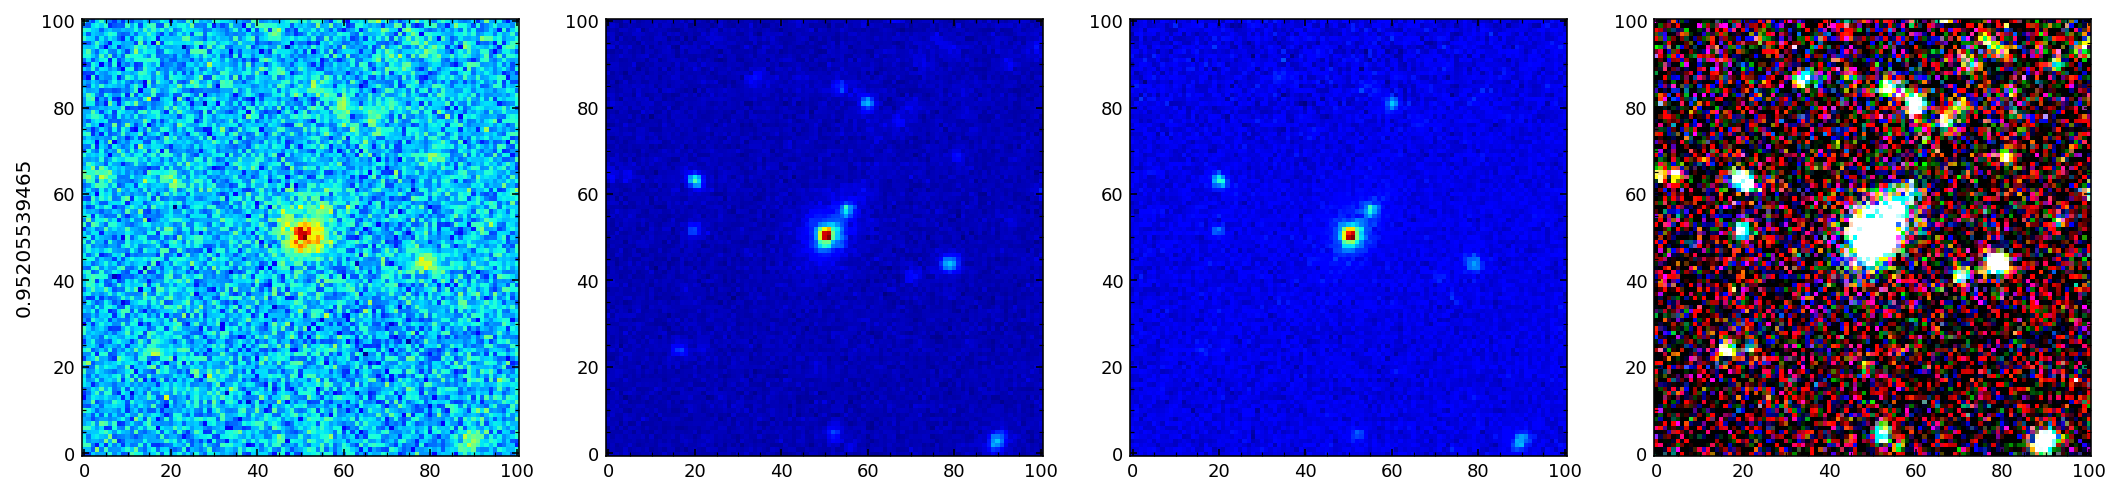

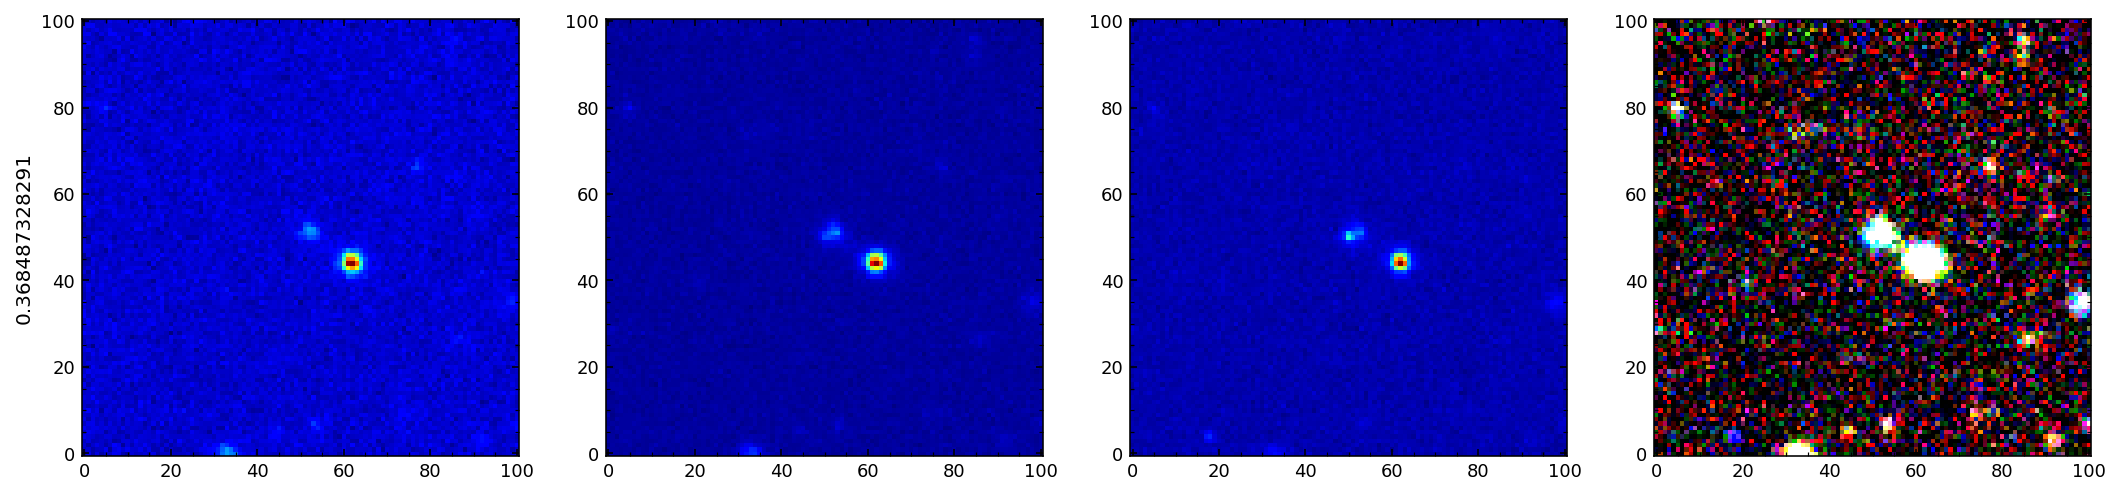

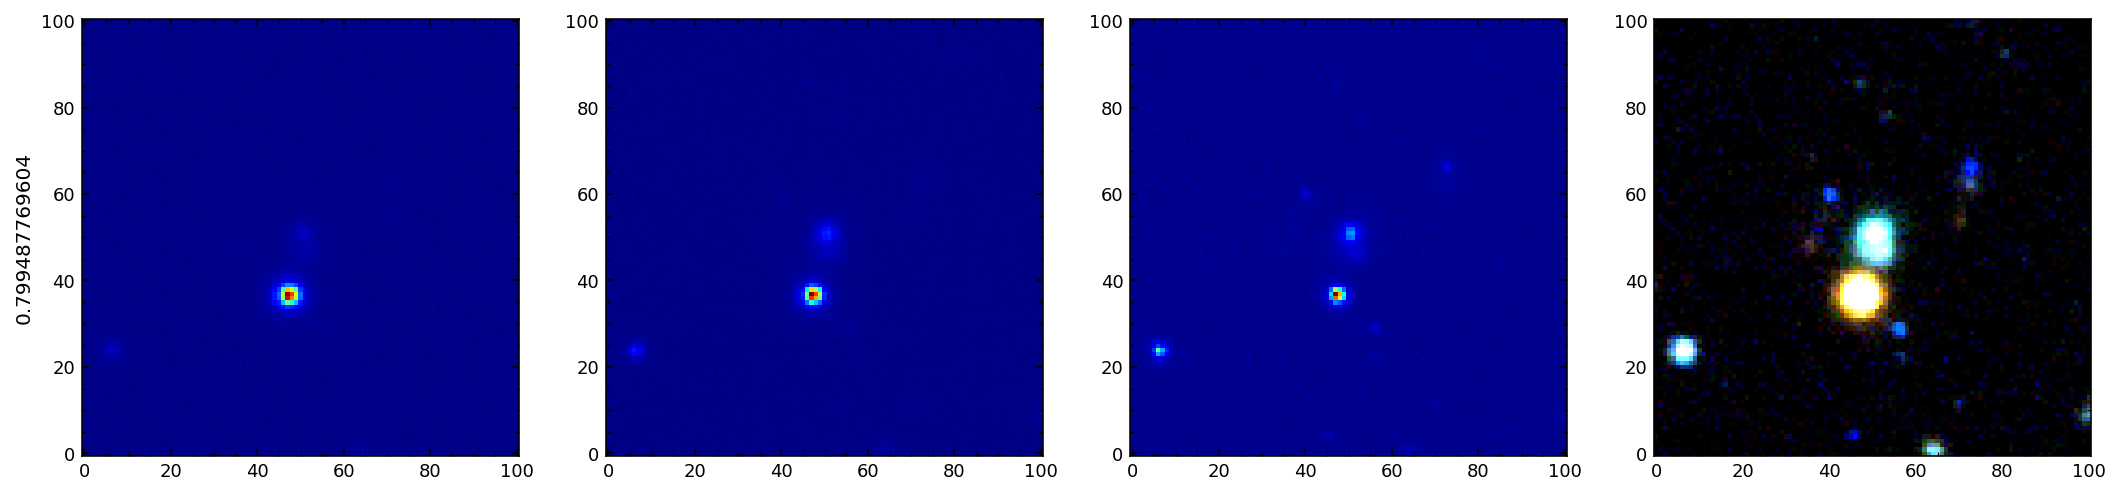

In [16]:
for pp, im in zip(P,images):
    show(im, pp, cut=100)

### check in validation dataset

- clean validation: remove repeated data points.

In [ ]:
with open(os.path.join(dsc.FLAGS.model_dir,'checkpoint')) as f:
    mid = f.readline().split('/')
    mid = mid[-2]+'_'+mid[-1][:-2]

In [ ]:
data_valid = np.load('/nfs/P100/DSC/data/1218/valid.npy')
clean_inds = np.unique(data_valid['obsid'],return_index=True)[1]
data_valid_cleaned = data_valid[clean_inds]

In [ ]:
#data_valid_mean = data_valid_cleaned['flux'].mean(axis=1)
#data_valid_cleaned['flux'] = data_valid_cleaned['flux'] - data_valid_mean[:,None]*np.ones([data_valid_mean.shape[0],4000])
loss, prob = dsc.eval(data_valid_cleaned['flux_norm'], data_valid_cleaned['label'])

In [ ]:
print loss.mean()
threshold = 0.5
bool_gt = data_valid_cleaned['label']
bool_es = prob[:,1]>threshold
size_eval = data_valid_cleaned.shape[0]
bool_dd = bool_gt*bool_es
bool_ss = (1-bool_gt)*(1-bool_es)
bool_ds = bool_gt*(1-bool_es)
bool_sd = (1-bool_gt)*bool_es
print 'd -> d', np.sum(bool_dd)/float(size_eval)  # d -> d
print 's -> s', np.sum(bool_ss)/float(size_eval)  # s -> s
print 'd -> s', np.sum(bool_ds)/float(size_eval)  # d -> s
print 's -> d', np.sum(bool_sd)/float(size_eval)  # s -> d
plt.hist(prob[bool_gt==1][:,1], 50, normed=True, histtype='step', label='double star')
plt.hist(prob[bool_gt==0][:,1], 50, normed=True, histtype='step', label='single star')
plt.xlabel('probability of double star')
plt.ylabel('PDF')
plt.legend()
plt.savefig('./test/%s_valid.png'%(mid))
plt.show()